In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

import scipy.spatial
from itertools import combinations
from scipy.spatial.distance import pdist
from scipy import optimize

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [2]:
plt.style.use('ggplot')

# Gauges

## Plot of the location of the gauges and a map of West Africa

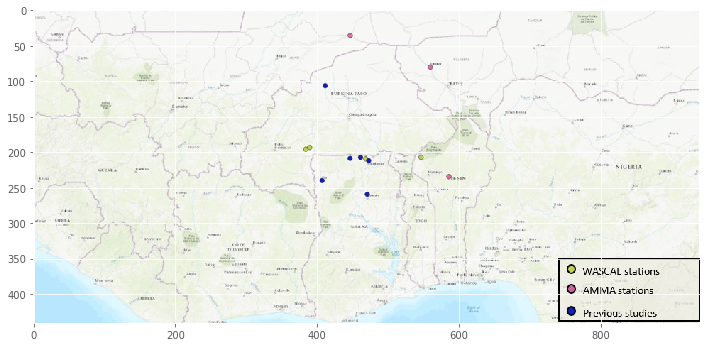

In [3]:
img1 = plt.imread('Data/location.jpg')

plt.figure(figsize = (12, 8))
plt.imshow(img1);

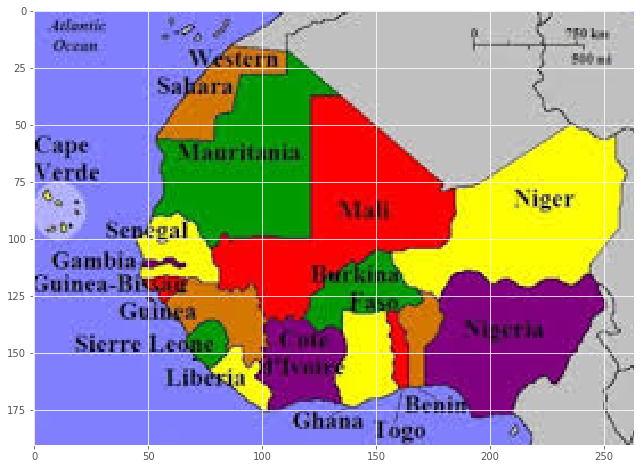

In [4]:
img2 = plt.imread('Data/afr.jpg')

plt.figure(figsize = (12, 8))
plt.imshow(img2);

## Load station locations

In [3]:
locations = pd.read_csv('Data\stations.txt', sep=' ', index_col=0)

locations.head(20)

,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


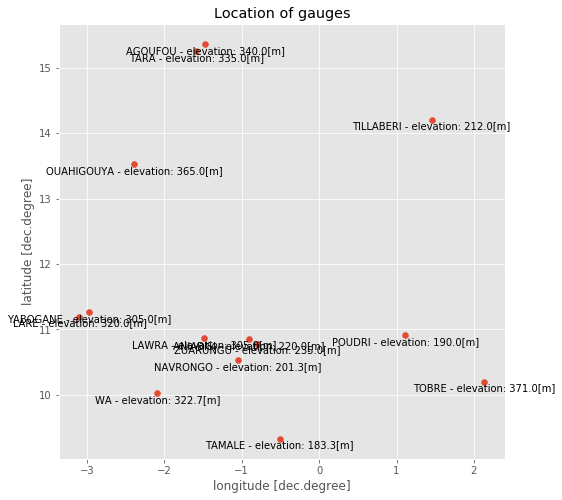

In [4]:
plt.figure(figsize=(8, 8))

plt.scatter(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)'])

for i in range(len(locations)):
    plt.text(locations['station_longitude(dec.degree)'][i], locations['station_latitude(dec.degree)'][i]  - 0.1, locations.index[i] + ' - elevation: ' + str(locations['station_altitude(m)'][i]) + '[m]', horizontalalignment='center', verticalalignment='center')

plt.xlabel('longitude [dec.degree]')
plt.ylabel('latitude [dec.degree]')
plt.title('Location of gauges')

plt.savefig('DataFigures/Location of gauges.png');

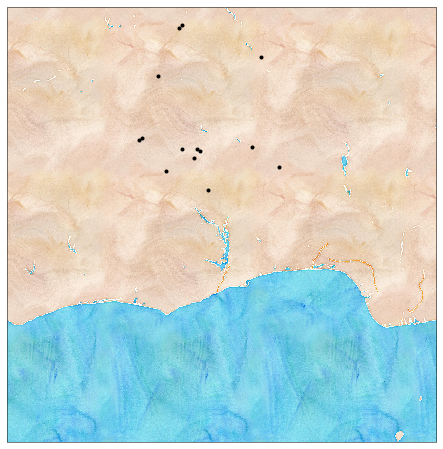

In [8]:
stamen_terrain = cimgt.Stamen('watercolor')
f = plt.figure(figsize=(8, 8))

# # Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([-8, 8, 0, 16])  


ax.add_image(stamen_terrain, 8)
ax.plot(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)'], 'k.', transform=ccrs.PlateCarree())

# for i in range(len(locations)):
#     ax.text(locations['station_longitude(dec.degree)'][i], locations['station_latitude(dec.degree)'][i], locations.index[i] + ' - elevation: ' + str(locations['station_altitude(m)'][i]) + '[m]', horizontalalignment='center', verticalalignment='center');

# If geoaxes doesn't work, please comment all lines above and unquote below
# plt.plot(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)'], '.')

plt.savefig('DataFigures/Location of gauges - Cartopy.png');

## We are going to calculate all the distances of the gauges (degrees to kilometers) and then plot the histogram.

### One decimal degree is approximately equal to 111.32 km near the equator

In [7]:
# Calculate the euclidean distance between each coordinate pair

all_distances = pdist(np.array(list(zip(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)']))))
print(f'All the distances are {len(all_distances):.0f}.')

all_distances = all_distances * 111.32  # dec. degrees to kms

# print(all_distances)

All the distances are 91.


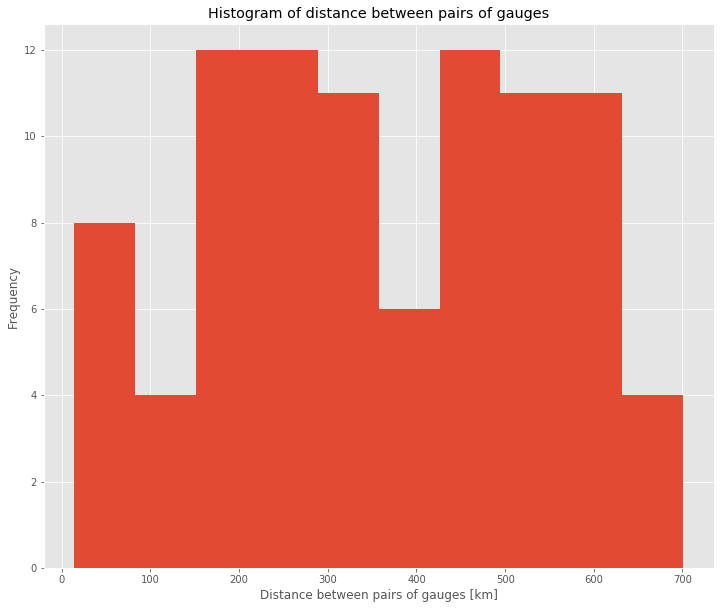

In [8]:
# Histogram

plt.figure(figsize=(12, 10))

plt.hist(all_distances, bins=10, density=False, histtype='stepfilled')
plt.xlabel('Distance between pairs of gauges [km]')
plt.ylabel('Frequency')
plt.title('Histogram of distance between pairs of gauges')

plt.savefig('DataFigures/Histogram of distance between pairs of gauges.png');

In [9]:
print(f'The smallest distance between pair of gauges is {min(all_distances):.2f} km.')
print(' ')
print(f'The largest distance between pair of gauges is {max(all_distances):.2f} km.')

The smallest distance between pair of gauges is 14.22 km.
 
The largest distance between pair of gauges is 700.70 km.


In [10]:
less50 = len(all_distances[all_distances < 50])
abv500 = len(all_distances[all_distances > 500])

       
print(f'The number of distancse between pair of gauges smaller than 50 km are {less50:.0f}.')
print(' ')
print(f'The number of distancse between pair of gauges larger than 500 km are {abv500:.0f}.')

The number of distancse between pair of gauges smaller than 50 km are 5.
 
The number of distancse between pair of gauges larger than 500 km are 22.


# Loading the ground measurements
## The point-observations are from three different datasets, as already presented in the dataframe of the locations.

# AMMA dataset (4 stations)

## 1. TILLABERI station (1999-2016)

In [128]:
station = 'TILLABERI'

TILLABERI = pd.DataFrame()

for year in range(1999, 2017, 1):
    
    file = f'Data\Gauges\AMMA\CL.Rain_Nig_BD_AMMA-CATCH_2020_05_20\AUTA IMPORT\CL.Rain_Nig-{station}-{year:.0f}.csv'
    dt = pd.read_csv(file, skiprows=25, sep=';', index_col=0) 
    dt.drop(labels=['Unnamed: 2'], axis=1, inplace=True)
    dt.rename(columns = {'# date_end_UTC': 'Date', 'var1': 'R[mm]'}, inplace=True)
    dt.index.rename('Date', inplace=True)
    
    TILLABERI = pd.concat([TILLABERI, dt]) 


TILLABERI[TILLABERI < 0] = 0.0

TILLABERI.head(100000)

,R[mm]
Date,
1999-01-01 06:00:00,0.0
1999-01-02 06:00:00,0.0
1999-01-03 06:00:00,0.0
1999-01-04 06:00:00,0.0
1999-01-05 06:00:00,0.0
...,...
2016-12-27 06:00:00,0.0
2016-12-28 06:00:00,0.0
2016-12-29 06:00:00,0.0


<Figure size 864x720 with 0 Axes>

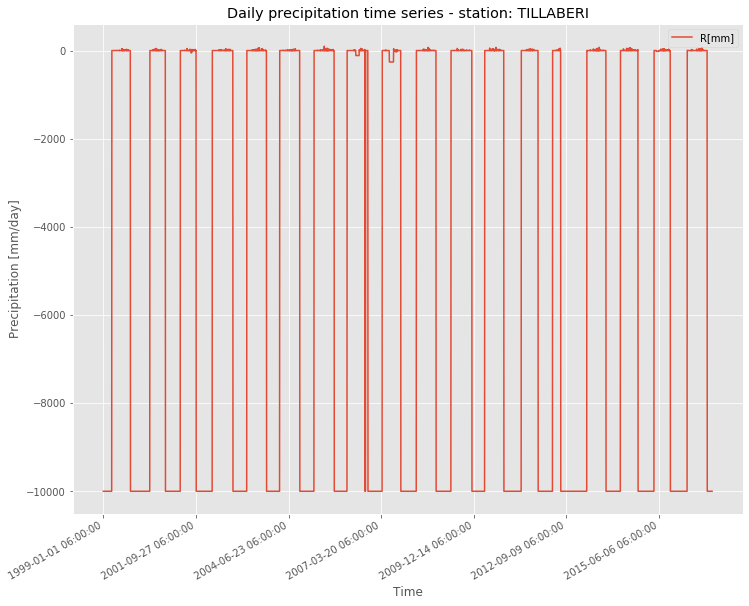

In [10]:
plt.figure(figsize=(12, 10))

TILLABERI.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}');

# plt.savefig(f'DataFigures/Daily precipitation time series - station: {station}.png');

In [108]:
ind = np.where(TILLABERI['R[mm]'] < 0)

ind

(array([   0,    1,    2, ..., 6572, 6573, 6574], dtype=int64),)

## Ungauged days are represented by negative values in the time series. We will change this value to np.nan and plot again.

In [110]:
TILLABERI[TILLABERI < 0] = np.nan

# TILLABERI.head(100000)

In [111]:
ind = np.where(TILLABERI['R[mm]'] < 0)

ind

(array([], dtype=int64),)

<Figure size 864x720 with 0 Axes>

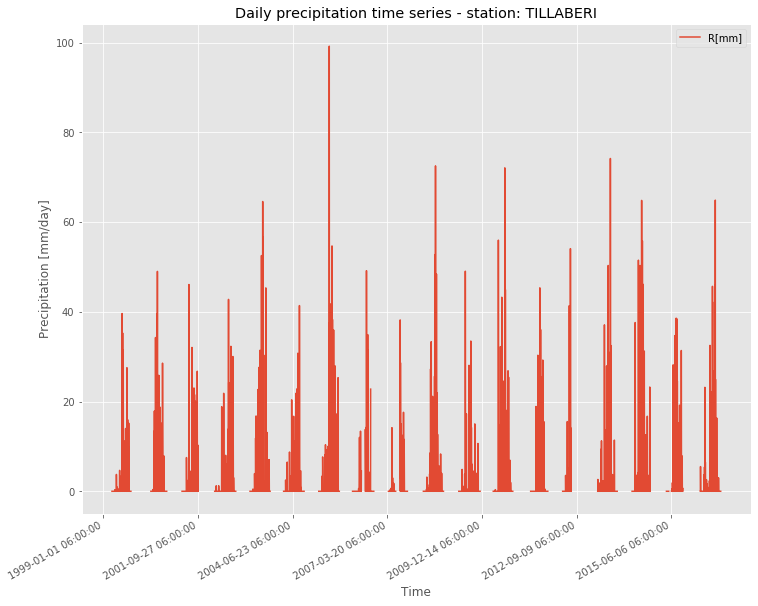

In [124]:
plt.figure(figsize=(12, 10))

TILLABERI.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}');

plt.savefig(f'DataFigures/station_TILLABERI.png');

In [130]:
# save the time-series in an organised form

TILLABERI.to_csv("OrganisedData\Gauges\stationTILLABERI.csv")

In [131]:
# load the time-series 

TILLABERI = pd.read_csv("OrganisedData\Gauges\stationTILLABERI.csv", index_col=0)

TILLABERI.head(100)

,R[mm]
Date,
1999-01-01 06:00:00,0.0
1999-01-02 06:00:00,0.0
1999-01-03 06:00:00,0.0
1999-01-04 06:00:00,0.0
1999-01-05 06:00:00,0.0
...,...
1999-04-06 06:00:00,0.0
1999-04-07 06:00:00,0.0
1999-04-08 06:00:00,0.0


## 2. TOBRE station (1999-2017)

In [116]:
station = 'TOBRE'

TOBRE = pd.DataFrame()

for year in range(1999, 2018, 1):
    
    file = f'Data\Gauges\AMMA\CL.Rain_O_BD_AMMA-CATCH_2020_05_20\AUTA IMPORT\CL.Rain_O_BD_AMMA-CATCH_2020_05_20\CL.Rain_O-{station}-{year:.0f}.csv'

    dt = pd.read_csv(file, skiprows=25, sep=';', index_col=0) 
    dt.drop(labels=['Unnamed: 2'], axis=1, inplace=True)
    dt.rename(columns = {'# date_end_UTC': 'Date', 'var1': 'R[mm]'}, inplace=True)
    dt.index.rename('Date', inplace=True)
    
    TOBRE = pd.concat([TOBRE, dt])


TOBRE[TOBRE < 0] = np.nan

TOBRE.head(100000)

,R[mm]
Date,
1999-01-01 06:00:00,0.00
1999-01-02 06:00:00,0.00
1999-01-03 06:00:00,0.00
1999-01-04 06:00:00,0.00
1999-01-05 06:00:00,0.00
...,...
2017-05-16 06:00:00,0.00
2017-05-17 06:00:00,0.00
2017-05-18 06:00:00,1.03


In [117]:
ind = np.where(TOBRE['R[mm]'] < 0)

ind

(array([], dtype=int64),)

<Figure size 864x720 with 0 Axes>

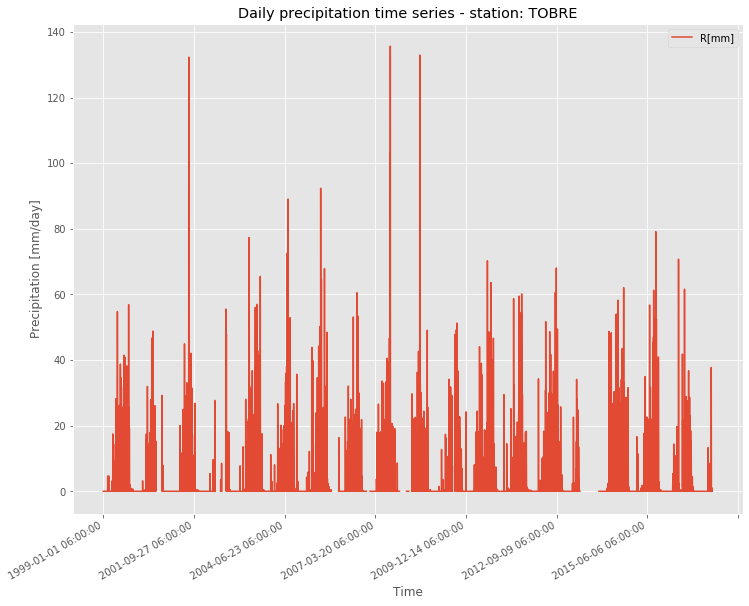

In [33]:
plt.figure(figsize=(12, 10))

TOBRE.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}');

plt.savefig(f'DataFigures\station_TOBRE.png');

In [118]:
print(TOBRE.iloc[1592])

R[mm]    0.0
Name: 2003-05-12 06:00:00, dtype: float64


In [119]:
# save the time-series in an organised form

TOBRE.to_csv("OrganisedData\Gauges\stationTOBRE.csv")

In [122]:
# load the time-series 

TOBRE = pd.read_csv("OrganisedData\Gauges\stationTOBRE.csv", index_col=0)

TOBRE.head(10000)

,R[mm]
Date,
1999-01-01,0.00
1999-01-02,0.00
1999-01-03,0.00
1999-01-04,0.00
1999-01-05,0.00
...,...
2017-05-16,0.00
2017-05-17,0.00
2017-05-18,1.03


## 3. TARA station (2004-2017, without 2007)

In [30]:
station = 'TARA'

TARA = pd.DataFrame()

for year in range(2004, 2007, 1):  # 2007 missing
    
    file = f'Data\Gauges\AMMA\TARAzip\CL.RainD_Gh-{station}-{year:.0f}.csv'

    dt = pd.read_csv(file, sep=';', skiprows=25, index_col=0) 
    dt.drop(labels=['Unnamed: 2'], axis=1, inplace=True)
    dt.rename(columns = {'# date_end_UTC': 'Date', 'var1': 'R[mm]'}, inplace=True)
    dt.index.rename('Date', inplace=True)
    
    TARA = pd.concat([TARA, dt])

for year in range(2008, 2018, 1):  # 2007 missing
    
    file = f'Data\Gauges\AMMA\TARAzip\CL.RainD_Gh-{station}-{year:.0f}.csv'

    dt = pd.read_csv(file, sep=';', skiprows=25, index_col=0) 
    dt.drop(labels=['Unnamed: 2'], axis=1, inplace=True)
    dt.rename(columns = {'# date_end_UTC': 'Date', 'var1': 'R[mm]'}, inplace=True)
    dt.index.rename('Date', inplace=True)
    
    TARA = pd.concat([TARA, dt])

TARA[TARA < 0] = np.nan

TARA.head(100000)

,R[mm]
Date,
2004-05-01 06:00:00,0.0
2004-05-02 06:00:00,0.0
2004-05-03 06:00:00,0.0
2004-05-04 06:00:00,0.0
2004-05-05 06:00:00,0.0
...,...
2017-12-27 06:00:00,0.0
2017-12-28 06:00:00,0.0
2017-12-29 06:00:00,0.0


## This code is created for the Princeton dataset, which we are not going to use after all. It will remain without use.

In [27]:
# station = 'TARA'

# # import from Princeton dataset
# file = f'Data\Gauges\AMMA\CL.RainD_Gh_BD_AMMA-CATCH_2020_05_20\Princeton data\data.txt'

# TARA = pd.read_csv(file, sep=' ', index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})
# TARA.head(10000)

In [26]:
# We have to import the data from 2017 too

# file = f'Data\Gauges\AMMA\CL.RainD_Gh_BD_AMMA-CATCH_2020_05_20\\new.xlsx'

# dt = pd.read_excel(file, header=None)
# dt.rename(columns = {0: 'Date', 1: 'R[mm]'}, inplace=True)
# dt.set_index('Date', inplace=True)


# dt.head()

In [25]:
# TARA = pd.concat([TARA, dt])

# TARA.head(10000)

In [31]:
ind = np.where(TARA['R[mm]'] < 0)

ind

(array([], dtype=int64),)

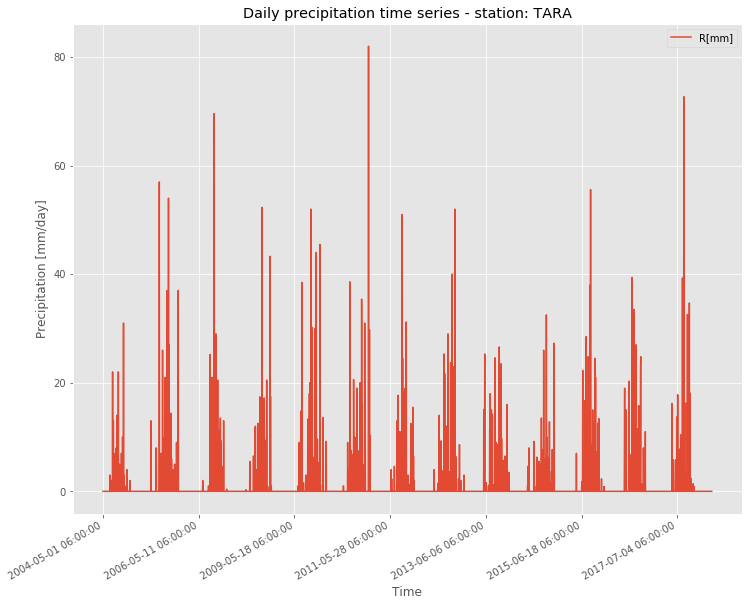

In [32]:
TARA.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}');

plt.savefig(f'DataFigures/station_TARA.png');

In [33]:
# save the time-series in an organised form

TARA.to_csv("OrganisedData\Gauges\stationTARA.csv")

In [60]:
# load the time-series 

TARA = pd.read_csv("OrganisedData\Gauges\stationTARA.csv", index_col=0)

# TARA.head(10000)

## 4. AGOUFOU (2003-2017)

In [20]:
station = 'AGOUFOU'

AGOUFOU = pd.DataFrame()

for year in range(2003, 2018, 1):
    
    file = f'Data\Gauges\AMMA\AGOUFOUzip\CL.RainD_Gh-{station}-{year:.0f}.csv'

    dt = pd.read_csv(file, sep=';', skiprows=25, index_col=0) 
    dt.drop(labels=['Unnamed: 2'], axis=1, inplace=True)
    dt.rename(columns = {'# date_end_UTC': 'Date', 'var1': 'R[mm]'}, inplace=True)
    dt.index.rename('Date', inplace=True)
    
    AGOUFOU = pd.concat([AGOUFOU, dt])


AGOUFOU[AGOUFOU < 0] = np.nan

AGOUFOU.head(100000)

,R[mm]
Date,
2003-05-01 06:00:00,0.0
2003-05-02 06:00:00,0.0
2003-05-03 06:00:00,0.0
2003-05-04 06:00:00,0.0
2003-05-05 06:00:00,0.0
...,...
2017-12-27 06:00:00,0.0
2017-12-28 06:00:00,0.0
2017-12-29 06:00:00,0.0


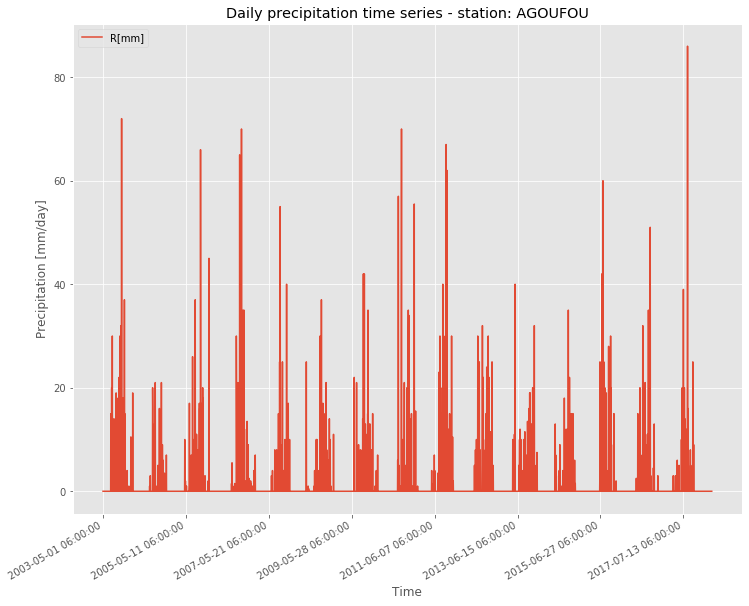

In [21]:
AGOUFOU.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}');

plt.savefig(f'DataFigures/station_AGOUFOU.png');

In [22]:
# save the time-series in an organised form

AGOUFOU.to_csv("OrganisedData\Gauges\stationAGOUFOU.csv")

In [14]:
# load the time-series 

AGOUFOU = pd.read_csv("OrganisedData\Gauges\stationAGOUFOU.csv", index_col=0)

# AGOUFOU.head(10000)

# Marloes dataset (6 stations)

## 1. LAWRA (1940-2002)

In [41]:
station = 'LAWRA'

file = 'Data\Gauges\Marloes\Lawra.xlsx'

LAWRA = pd.read_excel(file, index_col=0)
LAWRA.rename(columns = {'RR (mm)': 'R[mm]'}, inplace=True)
LAWRA.drop(LAWRA.columns[[1, 2, 3, 4, 5, 6, 7]], axis=1, inplace=True)

LAWRA.head(1000000)

,R[mm]
Date,
1940-01-01,0.0
1940-01-02,0.0
1940-01-03,0.0
1940-01-04,0.0
1940-01-05,0.0
...,...
2002-12-27,0.0
2002-12-28,0.0
2002-12-29,0.0


In [42]:
ind = np.where(LAWRA['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [43]:
ind = np.where(LAWRA['R[mm]'] > 800)  # missing values

ind

(array([  844,  5387,  5388, ..., 22977, 22978, 22979], dtype=int64),)

In [44]:
LAWRA[LAWRA > 800] = np.nan

<Figure size 864x720 with 0 Axes>

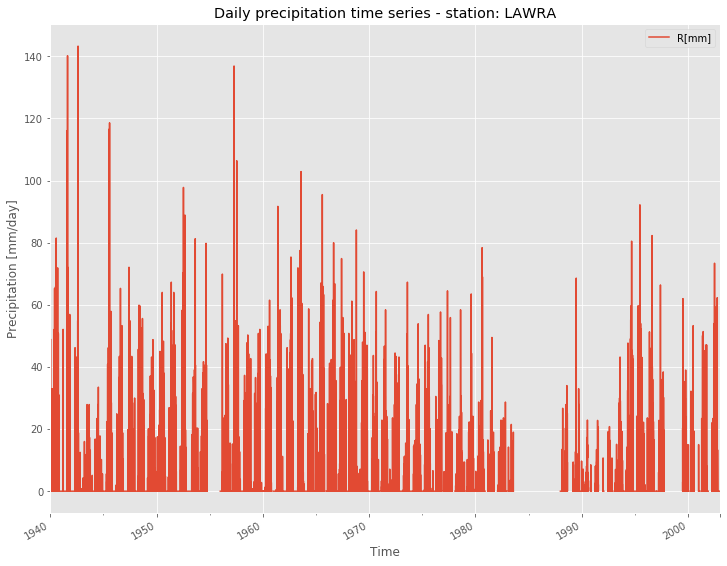

In [45]:
plt.figure(figsize=(12, 10))

LAWRA.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_LAWRA.png');

In [46]:
# save the time-series in an organised form

LAWRA.to_csv("OrganisedData\Gauges\stationLAWRA.csv")

In [15]:
# load the time-series 

LAWRA = pd.read_csv("OrganisedData\Gauges\stationLAWRA.csv", index_col=0)

# LAWRA.head(10000)

## 2. NAVRONGO (1960-2008)

In [49]:
station = 'NAVRONGO'

file = 'Data\Gauges\Marloes\\Navrongo.xlsx'

NAVRONGO = pd.read_excel(file, index_col=0)
NAVRONGO.rename(columns = {'RR (mm)': 'R[mm]'}, inplace=True)
NAVRONGO.drop(NAVRONGO.columns[[1, 2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)

NAVRONGO.head(1000000)

,R[mm]
Date,
1960-01-01,0.0
1960-01-02,0.0
1960-01-03,0.0
1960-01-04,0.0
1960-01-05,0.0
...,...
2008-05-27,0.0
2008-05-28,0.0
2008-05-29,0.0


In [50]:
ind = np.where(NAVRONGO['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [51]:
ind = np.where(NAVRONGO['R[mm]'] > 800)

ind

(array([ 7610,  7611,  7612,  7613,  7614,  7615,  7616,  7617,  7618,
         7619,  7620,  7621,  7622,  7623,  7624,  7625,  7626,  7627,
         7628,  7629,  7630,  7631,  7632,  7633,  7634,  7635,  7636,
         7637,  7638,  7639,  7702,  7703,  7704,  7705,  7706,  7707,
         7708,  7709,  7710,  7711,  7712,  7713,  7714,  7715,  7716,
         7717,  7718,  7719,  7720,  7721,  7722,  7723,  7724,  7725,
         7726,  7727,  7728,  7729, 12023, 12024, 12025, 12026, 12027,
        12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036,
        12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045,
        12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12296],
       dtype=int64),)

In [52]:
NAVRONGO[NAVRONGO > 800] = np.nan

<Figure size 864x720 with 0 Axes>

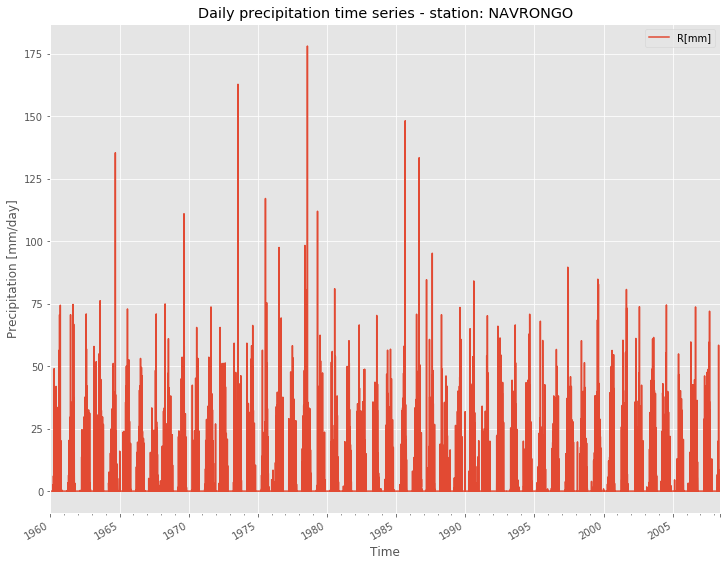

In [280]:
plt.figure(figsize=(12, 10))

NAVRONGO.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_NAVRONGO.png');

In [53]:
# save the time-series in an organised form

NAVRONGO.to_csv("OrganisedData\Gauges\stationNAVRONGO.csv")

In [16]:
# load the time-series 

NAVRONGO = pd.read_csv("OrganisedData\Gauges\stationNAVRONGO.csv", index_col=0)

# NAVRONGO.head(10000)

## 3. OUAHIGOUYA (1961-2009)

In [55]:
station = 'OUAHIGOUYA'

file = 'Data\Gauges\Marloes\\Ouahigouya 1961-2009.xlsx'

OUAHIGOUYA = pd.read_excel(file)
OUAHIGOUYA.drop(OUAHIGOUYA.columns[[0, 1, 2]], axis=1, inplace=True)
OUAHIGOUYA.set_index('Date', inplace=True)


OUAHIGOUYA.head(1000000)

,R[mm]
Date,
1961-01-01,0.0
1961-01-02,0.0
1961-01-03,0.0
1961-01-04,0.0
1961-01-05,0.0
...,...
2009-12-27,0.0
2009-12-28,0.0
2009-12-29,0.0


In [56]:
ind = np.where(OUAHIGOUYA['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [57]:
ind = np.where(OUAHIGOUYA['R[mm]'] > 800)

ind

(array([], dtype=int64),)

<Figure size 864x720 with 0 Axes>

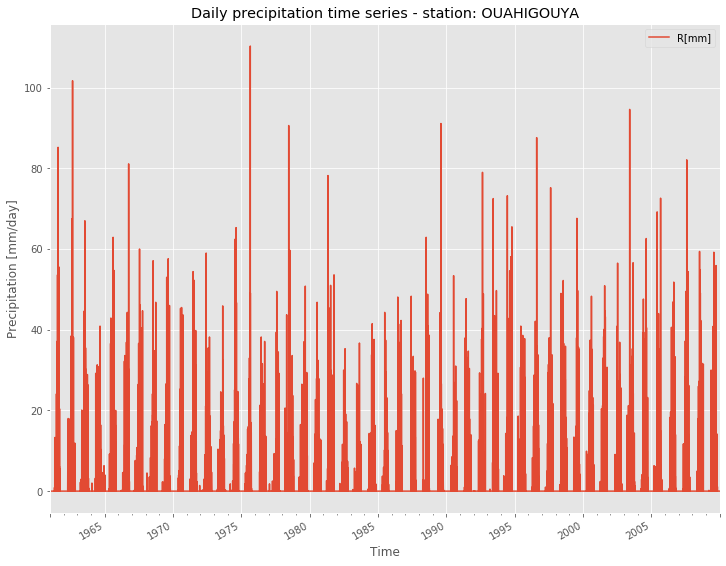

In [301]:
plt.figure(figsize=(12, 10))

OUAHIGOUYA.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_OUAHIGOUYA.png');

In [58]:
# save the time-series in an organised form

OUAHIGOUYA.to_csv("OrganisedData\Gauges\stationOUAHIGOUYA.csv")

In [17]:
# load the time-series 

OUAHIGOUYA = pd.read_csv("OrganisedData\Gauges\stationOUAHIGOUYA.csv", index_col=0)

# NAVRONGO.head(10000)

## 4. TAMALE (1960-2008)

In [60]:
station = 'TAMALE'

file = 'Data\Gauges\Marloes\\Tamale.xlsx'

TAMALE = pd.read_excel(file, index_col=0)
TAMALE.rename(columns = {'RR (mm)': 'R[mm]'}, inplace=True)
TAMALE.drop(TAMALE.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1, inplace=True)

TAMALE.head(1000000)

,R[mm]
Date,
1960-01-01,0.0
1960-01-02,0.0
1960-01-03,0.0
1960-01-04,0.0
1960-01-05,0.0
...,...
2008-11-26,0.0
2008-11-27,0.0
2008-11-28,0.0


In [61]:
TAMALE[~TAMALE.applymap(np.isreal).all(1)]  # spotted non-numerical values

,R[mm]
Date,


In [62]:
ind = np.where(TAMALE['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [63]:
ind = np.where(TAMALE['R[mm]'] > 800)

ind

(array([7913], dtype=int64),)

In [64]:
TAMALE[TAMALE > 800] = np.nan

<Figure size 864x720 with 0 Axes>

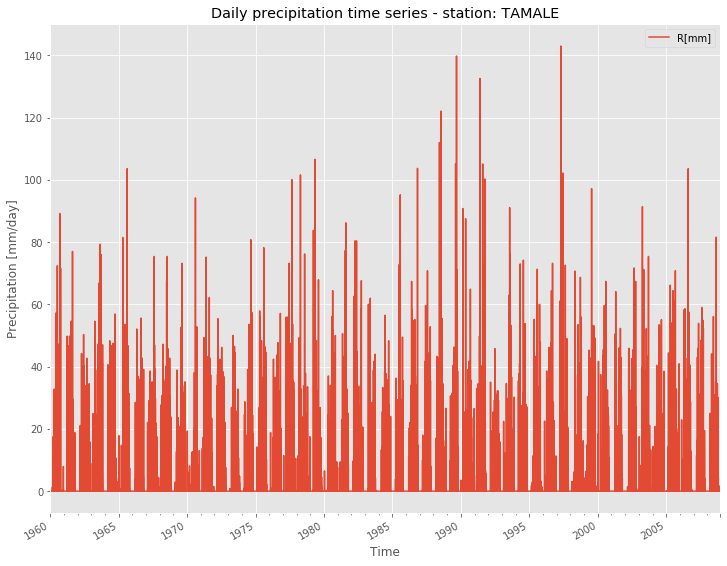

In [324]:
plt.figure(figsize=(12, 10))

TAMALE.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_TAMALE.png');

In [65]:
# save the time-series in an organised form

TAMALE.to_csv("OrganisedData\Gauges\stationTAMALE.csv")

In [18]:
# load the time-series 

TAMALE = pd.read_csv("OrganisedData\Gauges\stationTAMALE.csv", index_col=0)

# TAMALE.head(10000)

## 5. WA (1960-2004)

In [67]:
station = 'WA'

file = 'Data\Gauges\Marloes\\Wa.xlsx'

WA = pd.read_excel(file, index_col=0)
WA.rename(columns = {'RR. (mm)': 'R[mm]'}, inplace=True)
WA.drop(WA.columns[[1, 2, 3, 4, 5, 6, 7]], axis=1, inplace=True)

WA.head(1000000)

,R[mm]
Date,
1960-01-01,0.0
1960-01-02,0.0
1960-01-03,0.0
1960-01-04,0.0
1960-01-05,0.0
...,...
2004-10-27,7.8
2004-10-28,0.0
2004-10-29,0.0


In [68]:
ind = np.where(WA['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [69]:
ind = np.where(WA['R[mm]'] > 800)

ind

(array([ 7671,  7672,  7673,  7674,  7675,  7676,  7677,  7678,  7679,
         7680,  7681,  7682,  7683,  7684,  7685,  7686,  7687,  7688,
         7689,  7690,  7691,  7692,  7693,  7694,  7695,  7696,  7697,
         7698,  7699,  7700,  7701,  7702,  7703,  7704,  7705,  7706,
         7707,  7708,  7709,  7710,  7711,  7712,  7713,  7714,  7715,
         7716,  7717,  7718,  7719,  7720,  7721,  7722,  7723,  7724,
         7725,  7726,  7727,  7728,  7729,  8005,  8006,  8007,  8008,
         8009,  8010,  8011,  8012,  8013,  8014,  8015,  8016,  8017,
         8018,  8019,  8020,  8021,  8022,  8023,  8024,  8025,  8026,
         8027,  8028,  8029,  8030,  8031,  8032,  8033,  8034,  8035,
         8309,  8310,  8311,  8312,  8313,  8314,  8315,  8316,  8317,
         8318,  8319,  8320,  8321,  8322,  8323,  8324,  8325,  8326,
         8327,  8328,  8329,  8330,  8331,  8332,  8333,  8334,  8335,
         8336,  8337,  8338,  8339,  8340,  8341,  8342,  8343,  8344,
      

In [70]:
WA[WA > 800] = np.nan

<Figure size 864x720 with 0 Axes>

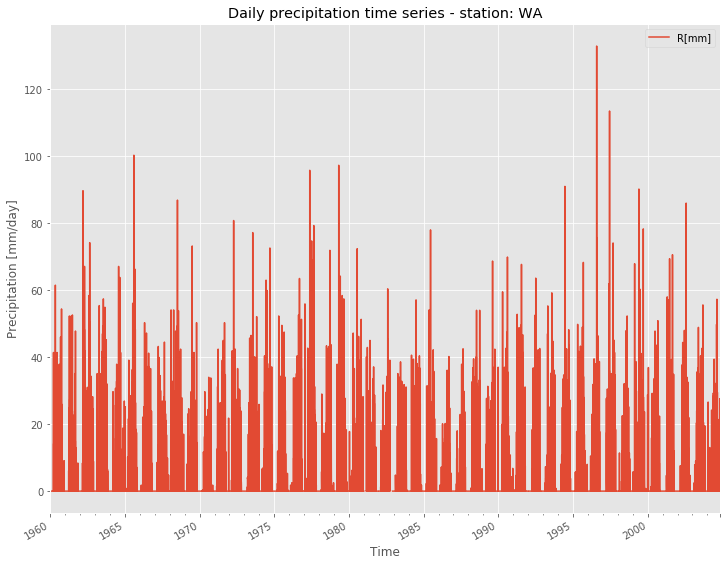

In [338]:
plt.figure(figsize=(12, 10))

WA.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_WA.png');

In [71]:
# save the time-series in an organised form

WA.to_csv("OrganisedData\Gauges\stationWA.csv")

In [19]:
# load the time-series 

WA = pd.read_csv("OrganisedData\Gauges\stationWA.csv", index_col=0)

# WA.head(10000)

## 6. ZUARUNGU (1939-2004)

In [73]:
station = 'ZUARUNGU'

file = 'Data\Gauges\Marloes\\Zuarungu.xlsx'

ZUARUNGU = pd.read_excel(file, index_col=0)
ZUARUNGU.rename(columns = {'RR (mm)': 'R[mm]'}, inplace=True)
ZUARUNGU.drop(ZUARUNGU.columns[[1, 2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)

ZUARUNGU.head(1000000)

,R[mm]
Date,
1939-01-01,0.0
1939-01-02,0.0
1939-01-03,0.0
1939-01-04,0.0
1939-01-05,0.0
...,...
2004-10-27,0.0
2004-10-28,0.0
2004-10-29,0.0


In [74]:
ind = np.where(ZUARUNGU['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [75]:
ind = np.where(ZUARUNGU['R[mm]'] > 800)

ind

(array([ 1246,  2008,  2009,  2010,  2011,  2012,  2013,  2014,  2015,
         2016,  2017,  2018,  2019,  2020,  2021,  2022,  2023,  2024,
         2025,  2026,  2027,  2028,  2029,  2030,  2031,  2032,  2033,
         2034,  2035,  2036,  2037,  2038,  2039,  2040,  2041,  2042,
         2043,  2044,  2045,  2046,  2047,  2048,  2049,  2050,  2051,
         2052,  2053,  2054,  2055,  2056,  2057,  2058,  2059,  2060,
         2061,  2062,  2063,  2064,  2065,  2066,  2067,  2068,  2069,
         3287,  3288,  3289,  3290,  3291,  3292,  3293,  3294,  3295,
         3296,  3297,  3298,  3299,  3300,  3301,  3302,  3303,  3304,
         3305,  3306,  3307,  3308,  3309,  3310,  3311,  3312,  3313,
         3314,  3315,  3316,  3317,  4352,  4353,  4354,  4355,  4356,
         4357,  4358,  4359,  4360,  4361,  4362,  4363,  4364,  4365,
         4366,  4367,  4368,  4369,  4370,  4371,  4372,  4373,  4374,
         4375,  4376,  4377,  4378,  4379,  4380,  4381,  4382,  4383,
      

In [76]:
ZUARUNGU[ZUARUNGU > 800] = np.nan

<Figure size 864x720 with 0 Axes>

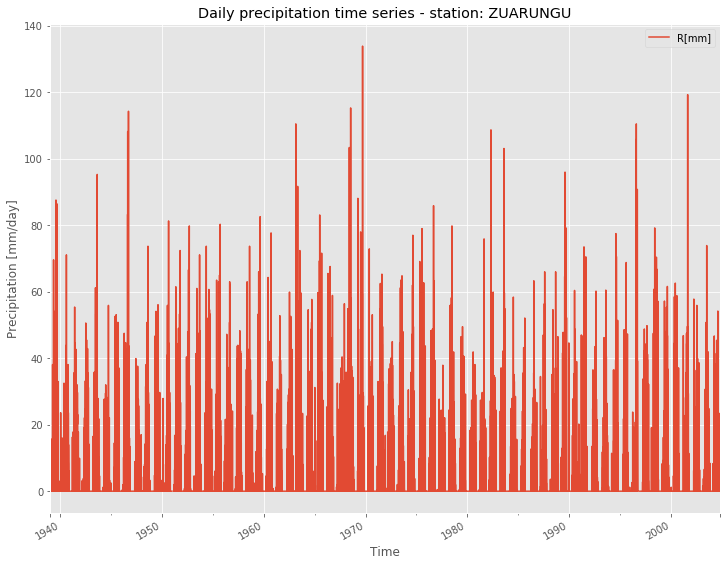

In [348]:
plt.figure(figsize=(12, 10))

ZUARUNGU.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_ZUARUNGU.png');

In [77]:
# save the time-series in an organised form

ZUARUNGU.to_csv("OrganisedData\Gauges\stationZUARUNGU.csv")

In [20]:
# load the time-series 

ZUARUNGU = pd.read_csv("OrganisedData\Gauges\stationZUARUNGU.csv", index_col=0)

# ZUARUNGU.head(10000)

# WASCAL dataset (4 stations)

## 1. ANIABISI (2014-2015)

In [131]:
station = 'ANIABISI'

file = 'Data\Gauges\WASCAL\Aniabisi - Ghana\Precipitation data Aniabisi_Up slope_2014-2015_daily.csv'

ANIABISI = pd.read_csv(file, sep=';', index_col='Date', parse_dates={'Date': ['Year', 'Month', 'Day']})
ANIABISI['R[mm]'] = (ANIABISI['Rain_01_mm'] + ANIABISI['Rain_02_mm']) / 2
ANIABISI.drop(ANIABISI.columns[[0, 1, 2]], axis=1, inplace=True)

ANIABISI.head(600)

,R[mm]
Date,
2014-01-01,NaN
2014-01-02,NaN
2014-01-03,NaN
2014-01-04,NaN
2014-01-05,NaN
...,...
2015-08-19,6.15
2015-08-20,0.15
2015-08-21,19.90


In [132]:
ind = np.where(ANIABISI['R[mm]'] < 0)

ind

(array([], dtype=int64),)

In [133]:
ANIABISI[~ANIABISI.applymap(np.isreal).all(1)]  # spotted non-numerical values

,R[mm]
Date,


<Figure size 864x720 with 0 Axes>

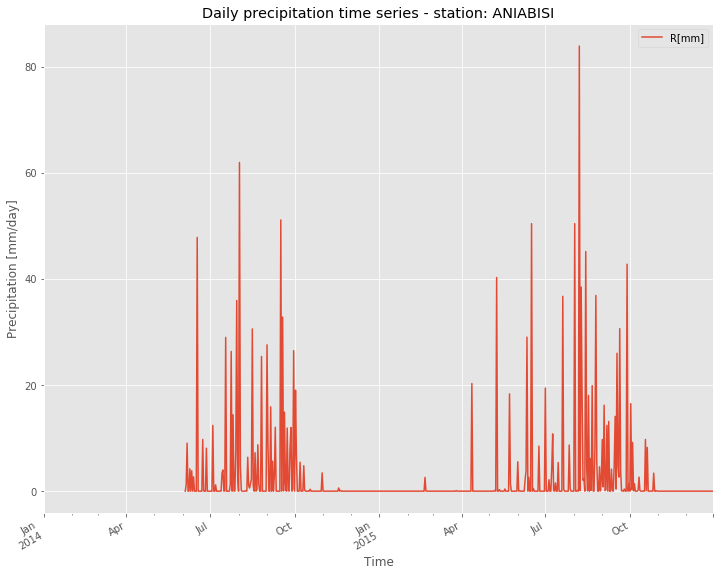

In [134]:
plt.figure(figsize=(12, 10))

ANIABISI.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_ANIABISI.png');

In [135]:
# save the time-series in an organised form

ANIABISI.to_csv("OrganisedData\Gauges\stationANIABISI.csv")

In [21]:
# load the time-series 

ANIABISI = pd.read_csv("OrganisedData\Gauges\stationANIABISI.csv", index_col=0)

# ANIABISI.head(10000)

## 2. POUDRI (2013-2015)

In [161]:
station = 'POUDRI'

file = 'Data\Gauges\WASCAL\Poudri - Benin\Climate data Poudri 2013-2015_daily.csv'

POUDRI = pd.read_csv(file, sep=';', index_col='Date', parse_dates={'Date': ['Year', 'Month', 'Day']})
POUDRI['R[mm]'] = (POUDRI['Rain_01_mm'] + POUDRI['Rain_02_mm']) / 2
POUDRI.drop(POUDRI.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1, inplace=True)

POUDRI.head(600)

,R[mm]
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
...,...
2014-08-19,1.00
2014-08-20,12.90
2014-08-21,4.60


In [163]:
ind = np.where(POUDRI['R[mm]'] > 600)

ind

(array([], dtype=int64),)

<Figure size 864x720 with 0 Axes>

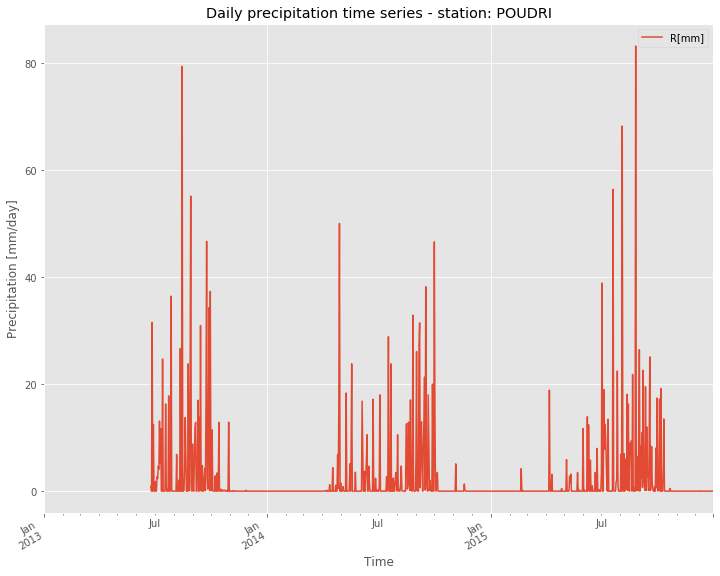

In [164]:
plt.figure(figsize=(12, 10))

POUDRI.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_POUDRI.png');

In [165]:
# save the time-series in an organised form

POUDRI.to_csv("OrganisedData\Gauges\stationPOUDRI.csv")

In [22]:
# load the time-series 

POUDRI = pd.read_csv("OrganisedData\Gauges\stationPOUDRI.csv", index_col=0)

# POUDRI.head(10000)

## 3. LARE (2013-2015)

In [10]:
station = 'LARE'

file = 'Data\Gauges\WASCAL\Lare - Burkina\lare.txt'  # Precipitation data Lare 2013-2015_daily.csv

LARE = pd.read_csv(file, sep=';', index_col='Date', parse_dates={'Date': ['Year', 'Month', 'Day']}) # 
LARE['R[mm]'] = (LARE['Rain_01_mm'] + LARE['Rain_02_mm']) / 2
LARE.drop(LARE.columns[[0, 1, 2]], axis=1, inplace=True)

LARE.head(600)

,R[mm]
Date,
2013-09-26,0.0
2013-09-27,0.2
2013-09-28,1.6
2013-09-29,0.0
2013-09-30,33.4
...,...
2015-05-14,0.0
2015-05-15,0.0
2015-05-16,0.0


In [12]:
ind = np.where(LARE['R[mm]'] < 0)

ind

(array([], dtype=int64),)

<Figure size 864x720 with 0 Axes>

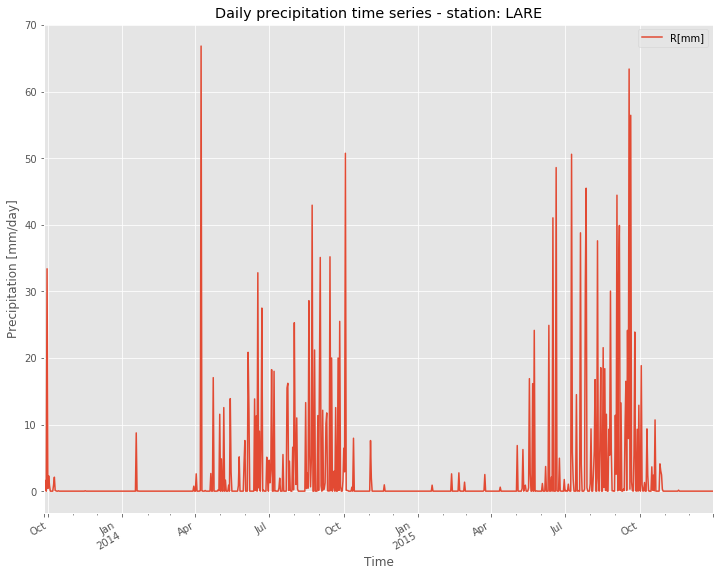

In [13]:
plt.figure(figsize=(12, 10))

LARE.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_LARE.png');

In [14]:
# save the time-series in an organised form

LARE.to_csv("OrganisedData\Gauges\stationLARE.csv")

In [23]:
# load the time-series 

LARE = pd.read_csv("OrganisedData\Gauges\stationLARE.csv", index_col=0)

# LARE.head(10000)

## 4. YABOGANE (2012-2015)

In [21]:
station = 'YABOGANE'

file = 'Data\Gauges\WASCAL\Yabogane - Burkina\yabogane.txt'  

YABOGANE = pd.read_csv(file, sep=';', index_col='Date', parse_dates={'Date': ['Year', 'Month', 'Day']}) # 
YABOGANE['R[mm]'] = (YABOGANE['Rain_01_mm'] + YABOGANE['Rain_02_mm']) / 2
YABOGANE.drop(YABOGANE.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1, inplace=True)

YABOGANE.head(600)

,R[mm]
Date,
2012-10-01,0.00
2012-10-02,0.45
2012-10-03,0.00
2012-10-04,2.80
2012-10-05,0.00
...,...
2014-05-19,0.00
2014-05-20,0.00
2014-05-21,0.00


In [22]:
ind = np.where(YABOGANE['R[mm]'] < 0)

ind

(array([], dtype=int64),)

<Figure size 864x720 with 0 Axes>

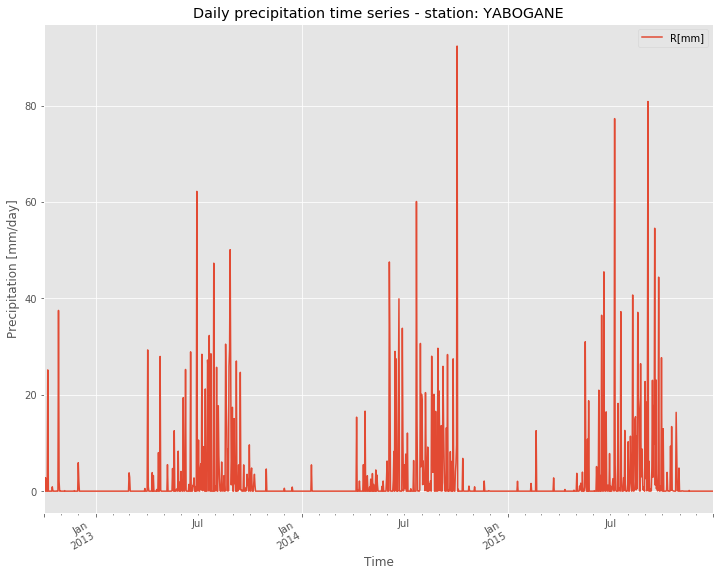

In [23]:
plt.figure(figsize=(12, 10))

YABOGANE.plot(figsize=(12, 10))

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily precipitation time series - station: {station}')

plt.savefig('DataFigures/station_YABOGANE.png');

In [24]:
# save the time-series in an organised form

YABOGANE.to_csv("OrganisedData\Gauges\stationYABOGANE.csv")

In [24]:
# load the time-series 

YABOGANE = pd.read_csv("OrganisedData\Gauges\stationYABOGANE.csv", index_col=0)

# YABOGANE.head(10000)

# Loading the satelite products

# MSWEP dataset
## The Multi-Source Weighted-Ensemble Precipitation (MSWEP v2.0) is a High spatial (0.1°) and temporal (3 hourly) resolution product that covers the period from 1979 to the near present. MSWEP optimally merges a wide range of gauge, satellite, and reanalysis data to provide reliable precipitation estimates over the entire globe. 


In [4]:
import netCDF4 as nc  # needed to handle nc files

In [5]:
main = 'Data\Remote_sensing\MSWEP\Daily_010deg'

# as an example we are going to load the file of 15/10/2000
time = '20001015'
 
fn = f'{main}\MSWEP_{time}00.nc'
# print(fn)

ds = nc.Dataset(fn)

## 01/01/1980 to 31/12/2016, 13.515 files

In [6]:
import datetime
from datetime import date

date = pd.date_range(start='19800101', end='20161231')
date = date.format(formatter=lambda x: x.strftime('%Y%m%d'))
# date = np.array(date)

In [7]:
len(date)

13515

In [8]:
# same example, more efficient
time = str(date[3344])
 
fn = f'{main}\MSWEP_{time}00.nc'
print(fn)

ds = nc.Dataset(fn)

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989022600.nc


In [9]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lon(1050), lat(890), t(1)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float64 t(t), float32 precipitation(t,lat,lon)
    groups: 



In [10]:
print(ds.__dict__)

OrderedDict()


In [11]:
# access all the dimensions

for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 1050

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 890

<class 'netCDF4._netCDF4.Dimension'>: name = 't', size = 1



In [12]:
ds.dimensions['lon']

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 1050

In [13]:
print(ds['lon'])

<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    units: degrees_east
    long_name: Longitude
    res: 0.1
unlimited dimensions: 
current shape = (1050,)
filling on, default _FillValue of 9.969209968386869e+36 used



In [14]:
print(ds['precipitation'])

<class 'netCDF4._netCDF4.Variable'>
float32 precipitation(t, lat, lon)
    _FillValue: -999000000.0
    long_name: precipitation
unlimited dimensions: 
current shape = (1, 890, 1050)
filling on


In [15]:
# save the fill value of precipitation in a variable

FillValue = -9999.0

In [16]:
prcp = np.array(ds['precipitation'][:])

In [17]:
prcp.shape

(1, 890, 1050)

In [18]:
prcp = prcp[0]

In [19]:
prcp.shape

(890, 1050)

In [20]:
prcp[700, 70]

-9999.0

In [21]:
longtitude = np.array(ds['lon'][:])

In [22]:
longtitude.shape

(1050,)

In [23]:
latitude = np.array(ds['lat'][:])

In [24]:
latitude.shape

(890,)

In [25]:
latitude[0]

-50.95

In [26]:
latitude[-1]

38.05

## We can see that the longtitude and latitude of the .nc arrays are expressed in dec. degrees (also verified through visual inspection in QGIS), such as the coordinates of the gauges. The next step is to extract the measurements for each station. We are going to first test the code manually and then run a loop for all the stations.

In [27]:
station = np.array(locations.index)

locations['station_latitude(dec.degree)'][station[2]]

15.2514

In [28]:
station[2]

'TARA'

In [29]:
len(station)

14

## We will first find the indices that match each station in the lon and lat arrays

In [30]:
index_lon = np.zeros(len(station))
index_lat = np.zeros(len(station))

In [32]:
# exmple in station TARA

a = (np.abs(longtitude-locations['station_longitude(dec.degree)'][station[2]])).argmin()
b = (np.abs(latitude-locations['station_latitude(dec.degree)'][station[2]])).argmin()

print(a, b)

243 661


In [34]:
# check
print(longtitude[a], locations['station_longitude(dec.degree)'][station[2]])
print(latitude[b], locations['station_latitude(dec.degree)'][station[2]])

-1.6268350810295544 -1.5855
15.224353205849269 15.2514


In [36]:
# Next step is to extract the indices of each station

for i in range(len(station)):
    
    index_lon[i] = int((np.abs(longtitude-locations['station_longitude(dec.degree)'][station[i]])).argmin())
    index_lat[i] = int((np.abs(latitude-locations['station_latitude(dec.degree)'][station[i]])).argmin())

In [37]:
index_lon

array([274., 281., 243., 245., 244., 249., 235., 254., 238., 251., 250.,
       270., 228., 230.])

In [39]:
# check our results

for i in range(len(station)):
    
    print(longtitude[int(index_lon[i])], locations['station_longitude(dec.degree)'][station[i]])
    print(latitude[int(index_lat[i])], locations['station_latitude(dec.degree)'][station[i]])

1.4761201143946607 1.4545
14.223228346456693 14.2043
2.1767874165872243 2.1335
10.218728908886384 10.1991
-1.6268350810295544 -1.5855
15.224353205849269 15.2514
-1.4266444232602495 -1.47
15.324465691788518 15.36
-1.526739752144902 -1.48333
10.819403824521928 10.86667
-1.0262631077216398 -1.05
10.519066366704159 10.53
-2.4275977121067704 -2.39
13.522440944881879 13.52
-0.5257864632983811 -0.51
9.317716535433064 9.33
-2.127311725452813 -2.09
10.018503937007871 10.03
-0.8260724499523349 -0.8
10.819403824521928 10.7833
-0.9261677788369873 -0.9106289
10.819403824521928 10.84725086
1.075738798856051 1.11189718
10.91951631046119 10.91393386
-3.128265014299334 -3.095351
11.21985376827896 11.192883
-2.928074356530029 -2.96816798
11.21985376827896 11.261641


In [70]:
TILLABERI_1pixels = np.zeros(len(date))
TOBRE_1pixels = np.zeros(len(date))
TARA_1pixels = np.zeros(len(date))
AGOUFOU_1pixels = np.zeros(len(date))
LAWRA_1pixels = np.zeros(len(date))
NAVRONGO_1pixels = np.zeros(len(date))
OUAHIGOUYA_1pixels = np.zeros(len(date))
TAMALE_1pixels = np.zeros(len(date))
WA_1pixels = np.zeros(len(date))
ZUARUNGU_1pixels = np.zeros(len(date))
ANIABISI_1pixels = np.zeros(len(date))
POUDRI_1pixels = np.zeros(len(date))
LARE_1pixels = np.zeros(len(date))
YABOGANE_1pixels = np.zeros(len(date))

In [72]:
ANIABISI_1pixels.shape

(13515,)

In [73]:
# loop for all files

# REMEMBER: prec = (latitude, longtitude)

for day in range(len(date)):
    
    time = str(date[day])
 
    fn = f'{main}\MSWEP_{time}00.nc'
#     print(fn)

    ds = nc.Dataset(fn)
    prcp = np.array(ds['precipitation'][:])
    prcp = prcp[0]
#     print(prcp.shape)

    TILLABERI_1pixels[day] = prcp[int(index_lat[0]), int(index_lon[0])]
    TOBRE_1pixels[day] = prcp[int(index_lat[1]), int(index_lon[1])]
    TARA_1pixels[day] = prcp[int(index_lat[2]), int(index_lon[2])]
    AGOUFOU_1pixels[day] = prcp[int(index_lat[3]), int(index_lon[3])]
    LAWRA_1pixels[day] = prcp[int(index_lat[4]), int(index_lon[4])]
    NAVRONGO_1pixels[day] = prcp[int(index_lat[5]), int(index_lon[5])]
    OUAHIGOUYA_1pixels[day] = prcp[int(index_lat[6]), int(index_lon[6])]
    TAMALE_1pixels[day] = prcp[int(index_lat[7]), int(index_lon[7])]
    WA_1pixels[day] = prcp[int(index_lat[8]), int(index_lon[8])]
    ZUARUNGU_1pixels[day] = prcp[int(index_lat[9]), int(index_lon[9])]
    ANIABISI_1pixels[day] = prcp[int(index_lat[10]), int(index_lon[10])]
    POUDRI_1pixels[day] = prcp[int(index_lat[11]), int(index_lon[11])]
    LARE_1pixels[day] = prcp[int(index_lat[12]), int(index_lon[12])]
    YABOGANE_1pixels[day] = prcp[int(index_lat[13]), int(index_lon[13])]

C:\Users\panag\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  


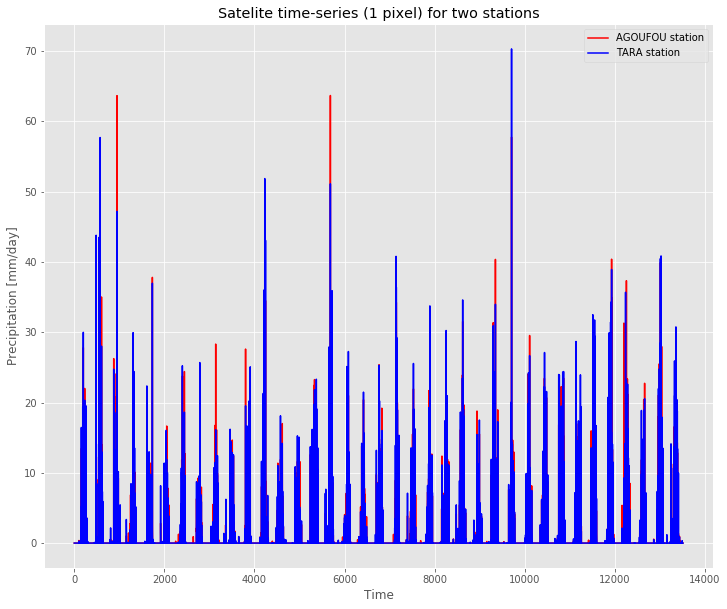

In [78]:
# let's make a plot to check the results

plt.figure(figsize=(12, 10))

plt.plot(np.linspace(0, len(AGOUFOU_1pixels), len(AGOUFOU_1pixels)), AGOUFOU_1pixels, 'r', label='AGOUFOU station')
plt.plot(np.linspace(0, len(AGOUFOU_1pixels), len(AGOUFOU_1pixels)), TARA_1pixels, 'B', label='TARA station')

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
# plt.gcf().autofmt_xdate()
plt.title(f'Satelite time-series (1 pixel) for two stations')
plt.legend();

# plt.savefig('DataFigures/Satelite time-series (1 pixel) for two stations.png');

In [93]:
# save the time-series in an organised form

np.savetxt("OrganisedData\MSWEP\TILLABERI_1pixels.txt", TILLABERI_1pixels)
np.savetxt("OrganisedData\MSWEP\TOBRE_1pixels.txt", TOBRE_1pixels)
np.savetxt("OrganisedData\MSWEP\TARA_1pixels.txt", TARA_1pixels)
np.savetxt("OrganisedData\MSWEP\AGOUFOU_1pixels.txt", AGOUFOU_1pixels)
np.savetxt("OrganisedData\MSWEP\LAWRA_1pixels.txt", LAWRA_1pixels)
np.savetxt("OrganisedData\MSWEP\\NAVRONGO_1pixels.txt", NAVRONGO_1pixels)
np.savetxt("OrganisedData\MSWEP\OUAHIGOUYA_1pixels.txt", OUAHIGOUYA_1pixels)
np.savetxt("OrganisedData\MSWEP\TAMALE_1pixels.txt", TAMALE_1pixels)
np.savetxt("OrganisedData\MSWEP\WA_1pixels.txt", WA_1pixels)
np.savetxt("OrganisedData\MSWEP\ZUARUNGU_1pixels.txt", ZUARUNGU_1pixels)
np.savetxt("OrganisedData\MSWEP\ANIABISI_1pixels.txt", ANIABISI_1pixels)
np.savetxt("OrganisedData\MSWEP\POUDRI_1pixels.txt", POUDRI_1pixels)
np.savetxt("OrganisedData\MSWEP\LARE_1pixels.txt", LARE_1pixels)
np.savetxt("OrganisedData\MSWEP\YABOGANE_1pixels.txt", YABOGANE_1pixels)

In [5]:
# load the time-series in an organised form

TILLABERI_1pixels = np.loadtxt("OrganisedData\MSWEP\TILLABERI_1pixels.txt")
TOBRE_1pixels = np.loadtxt("OrganisedData\MSWEP\TOBRE_1pixels.txt")
TARA_1pixels = np.loadtxt("OrganisedData\MSWEP\TARA_1pixels.txt")
AGOUFOU_1pixels = np.loadtxt("OrganisedData\MSWEP\AGOUFOU_1pixels.txt")
LAWRA_1pixels = np.loadtxt("OrganisedData\MSWEP\LAWRA_1pixels.txt")
NAVRONGO_1pixels = np.loadtxt("OrganisedData\MSWEP\\NAVRONGO_1pixels.txt")
OUAHIGOUYA_1pixels = np.loadtxt("OrganisedData\MSWEP\OUAHIGOUYA_1pixels.txt")
TAMALE_1pixels = np.loadtxt("OrganisedData\MSWEP\TAMALE_1pixels.txt")
WA_1pixels = np.loadtxt("OrganisedData\MSWEP\WA_1pixels.txt")
ZUARUNGU_1pixels = np.loadtxt("OrganisedData\MSWEP\ZUARUNGU_1pixels.txt")
ANIABISI_1pixels = np.loadtxt("OrganisedData\MSWEP\ANIABISI_1pixels.txt")
POUDRI_1pixels = np.loadtxt("OrganisedData\MSWEP\POUDRI_1pixels.txt")
LARE_1pixels = np.loadtxt("OrganisedData\MSWEP\LARE_1pixels.txt")
YABOGANE_1pixels = np.loadtxt("OrganisedData\MSWEP\YABOGANE_1pixels.txt")

In [40]:
df = pd.DataFrame(date, columns=['Date'])
df['Date'] = pd.to_datetime(df.Date)

df

,Date
0,1980-01-01
1,1980-01-02
2,1980-01-03
3,1980-01-04
4,1980-01-05
...,...
13510,2016-12-27
13511,2016-12-28
13512,2016-12-29
13513,2016-12-30


In [46]:
TILLABERI32x32 = pd.concat([df, pd.DataFrame(TILLABERI32x32)], axis=1) 
TILLABERI32x32.set_index('Date', inplace=True)

TILLABERI32x32.to_csv("OrganisedData\TILLABERI32x32.csv")
TILLABERI32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
TOBRE32x32 = pd.concat([df, pd.DataFrame(TOBRE32x32)], axis=1) 
TOBRE32x32.set_index('Date', inplace=True)

TOBRE32x32.to_csv("OrganisedData\TOBRE32x32.csv")
TOBRE32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.23,0.26,0.21,0.24,0.27,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0


In [48]:
TARA32x32 = pd.concat([df, pd.DataFrame(TARA32x32)], axis=1) 
TARA32x32.set_index('Date', inplace=True)

TARA32x32.to_csv("OrganisedData\TARA32x32.csv")
# TARA32x32

In [49]:
AGOUFOU32x32 = pd.concat([df, pd.DataFrame(AGOUFOU32x32)], axis=1) 
AGOUFOU32x32.set_index('Date', inplace=True)

AGOUFOU32x32.to_csv("OrganisedData\AGOUFOU32x32.csv")
AGOUFOU32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
LAWRA32x32 = pd.concat([df, pd.DataFrame(LAWRA32x32)], axis=1) 
LAWRA32x32.set_index('Date', inplace=True)

LAWRA32x32.to_csv("OrganisedData\LAWRA32x32.csv")
LAWRA32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
NAVRONGO32x32 = pd.concat([df, pd.DataFrame(NAVRONGO32x32)], axis=1) 
NAVRONGO32x32.set_index('Date', inplace=True)

NAVRONGO32x32.to_csv("OrganisedData\\NAVRONGO32x32.csv")
NAVRONGO32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.6,0.54,0.49,0.45,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0


In [52]:
OUAHIGOUYA32x32 = pd.concat([df, pd.DataFrame(OUAHIGOUYA32x32)], axis=1) 
OUAHIGOUYA32x32.set_index('Date', inplace=True)

OUAHIGOUYA32x32.to_csv("OrganisedData\OUAHIGOUYA32x32.csv")
OUAHIGOUYA32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
TAMALE32x32 = pd.concat([df, pd.DataFrame(TAMALE32x32)], axis=1) 
TAMALE32x32.set_index('Date', inplace=True)

TAMALE32x32.to_csv("OrganisedData\TAMALE32x32.csv")
# TAMALE32x32

In [54]:
WA32x32 = pd.concat([df, pd.DataFrame(WA32x32)], axis=1) 
WA32x32.set_index('Date', inplace=True)

WA32x32.to_csv("OrganisedData\WA32x32.csv")
# WA32x32

In [55]:
ZUARUNGU32x32 = pd.concat([df, pd.DataFrame(ZUARUNGU32x32)], axis=1) 
ZUARUNGU32x32.set_index('Date', inplace=True)

ZUARUNGU32x32.to_csv("OrganisedData\ZUARUNGU32x32.csv")
ZUARUNGU32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.64,0.57,0.51,0.47,0.42,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0


In [56]:
ANIABISI32x32 = pd.concat([df, pd.DataFrame(ANIABISI32x32)], axis=1) 
ANIABISI32x32.set_index('Date', inplace=True)

ANIABISI32x32.to_csv("OrganisedData\ANIABISI32x32.csv")
# ANIABISI32x32

In [57]:
POUDRI32x32 = pd.concat([df, pd.DataFrame(POUDRI32x32)], axis=1) 
POUDRI32x32.set_index('Date', inplace=True)

POUDRI32x32.to_csv("OrganisedData\POUDRI32x32.csv")
POUDRI32x32

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
LARE32x32 = pd.concat([df, pd.DataFrame(LARE32x32)], axis=1) 
LARE32x32.set_index('Date', inplace=True)

LARE32x32.to_csv("OrganisedData\LARE32x32.csv")
# LARE32x32

In [59]:
YABOGANE32x32 = pd.concat([df, pd.DataFrame(YABOGANE32x32)], axis=1) 
YABOGANE32x32.set_index('Date', inplace=True)

YABOGANE32x32.to_csv("OrganisedData\YABOGANE32x32.csv")
# YABOGANE32x32

In [5]:
# load the .csv 

TILLABERI32x32 = pd.read_csv("OrganisedData\MSWEP\TILLABERI32x32.csv", index_col=0)
TOBRE32x32 = pd.read_csv("OrganisedData\MSWEP\TOBRE32x32.csv", index_col=0)
TARA32x32 = pd.read_csv("OrganisedData\MSWEP\TARA32x32.csv", index_col=0)
AGOUFOU32x32 = pd.read_csv("OrganisedData\MSWEP\AGOUFOU32x32.csv", index_col=0)
LAWRA32x32 = pd.read_csv("OrganisedData\MSWEP\LAWRA32x32.csv", index_col=0)
NAVRONGO32x32 = pd.read_csv("OrganisedData\MSWEP\\NAVRONGO32x32.csv", index_col=0)
OUAHIGOUYA32x32 = pd.read_csv("OrganisedData\MSWEP\OUAHIGOUYA32x32.csv", index_col=0)
TAMALE32x32 = pd.read_csv("OrganisedData\MSWEP\TAMALE32x32.csv", index_col=0)
WA32x32 = pd.read_csv("OrganisedData\MSWEP\WA32x32.csv", index_col=0)
ZUARUNGU32x32 = pd.read_csv("OrganisedData\MSWEP\ZUARUNGU32x32.csv", index_col=0)
ANIABISI32x32 = pd.read_csv("OrganisedData\MSWEP\ANIABISI32x32.csv", index_col=0)
POUDRI32x32 = pd.read_csv("OrganisedData\MSWEP\POUDRI32x32.csv", index_col=0)
LARE32x32 = pd.read_csv("OrganisedData\MSWEP\LARE32x32.csv", index_col=0)
YABOGANE32x32 = pd.read_csv("OrganisedData\MSWEP\YABOGANE32x32.csv", index_col=0)

# ZUARUNGU32x32.head(10000)

# Extract the 32x32-pixel arrays

In [41]:
TILLABERI32x32 = np.zeros((len(date), 32 * 32))
TOBRE32x32 = np.zeros((len(date), 32 * 32))
TARA32x32 = np.zeros((len(date), 32 * 32))
AGOUFOU32x32 = np.zeros((len(date), 32 * 32))
LAWRA32x32 = np.zeros((len(date), 32 * 32))
NAVRONGO32x32 = np.zeros((len(date), 32 * 32))
OUAHIGOUYA32x32 = np.zeros((len(date), 32 * 32))
TAMALE32x32 = np.zeros((len(date), 32 * 32))
WA32x32 = np.zeros((len(date), 32 * 32))
ZUARUNGU32x32 = np.zeros((len(date), 32 * 32))
ANIABISI32x32 = np.zeros((len(date), 32 * 32))
POUDRI32x32 = np.zeros((len(date), 32 * 32))
LARE32x32 = np.zeros((len(date), 32 * 32))
YABOGANE32x32 = np.zeros((len(date), 32 * 32))

In [42]:
len(TOBRE32x32[0, :])

1024

In [ ]:
# loop for all files

# REMEMBER: prec = (latitude, longtitude)

for day in range(len(date)):
    
    time = str(date[day])
 
    fn = f'{main}\MSWEP_{time}00.nc'
    print(fn)
    
    
    ds = nc.Dataset(fn)
    prcp = np.array(ds['precipitation'][:])
    prcp = prcp[0]
#     print(prcp.shape)


    i = -1
    for row in range(16, -16, -1):  # 16 to -15
        for col in range(-16, 16, 1):
            
            i += 1  # index of axis=1
#             print(row + 16, col + 16, i)
            
            # NW to SE

            TILLABERI32x32[day, i] = prcp[int(index_lat[0] + row), int(index_lon[0] + col)] # 32 to -31
            TOBRE32x32[day, i] = prcp[int(index_lat[1] + row), int(index_lon[1] + col)]
            TARA32x32[day, i] = prcp[int(index_lat[2] + row), int(index_lon[2] + col)]
            AGOUFOU32x32[day, i] = prcp[int(index_lat[3] + row), int(index_lon[3] + col)]
            LAWRA32x32[day, i] = prcp[int(index_lat[4] + row), int(index_lon[4] + col)]
            NAVRONGO32x32[day, i] = prcp[int(index_lat[5] + row), int(index_lon[5] + col)]
            OUAHIGOUYA32x32[day, i] = prcp[int(index_lat[6] + row), int(index_lon[6] + col)]
            TAMALE32x32[day, i] = prcp[int(index_lat[7] + row), int(index_lon[7] + col)]
            WA32x32[day, i] = prcp[int(index_lat[8] + row), int(index_lon[8] + col)]
            ZUARUNGU32x32[day, i] = prcp[int(index_lat[9] + row), int(index_lon[9] + col)]
            ANIABISI32x32[day, i] = prcp[int(index_lat[10] + row), int(index_lon[10] + col)]
            POUDRI32x32[day, i] = prcp[int(index_lat[11] + row), int(index_lon[11] + col)]
            LARE32x32[day, i] = prcp[int(index_lat[12] + row), int(index_lon[12] + col)]
            YABOGANE32x32[day, i] = prcp[int(index_lat[13] + row), int(index_lon[13] + col)]

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980010900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980011700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980051900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980052900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980053000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980053100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980060100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980060200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980060300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980060400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980100600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980100700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980100800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980100900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980101900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980102000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980102100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1980102200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981022800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981030900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981031000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981071900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981072700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981112800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981112900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981113000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981120900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981121000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981121100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981121200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981121300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1981121400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982041700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982041800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982041900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982042900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982043000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982050100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982050200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982050300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982090900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1982091900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983012900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983013000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983013100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983020700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983061900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983062700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983102700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983102800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983102900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983103000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983103100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983110900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983111000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983111100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1983111200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984031500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984031600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984031700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984031800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984031900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984032900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984033000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984033100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984080900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984081800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984122900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984123000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1984123100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985010100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985010200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985010300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985010400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985010500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985010600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985051900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985052700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985092900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985093000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985100900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985101000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985101100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985101200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985101300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985101400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1985101500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986021600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986021700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986021800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986021900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986022800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986030100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986030200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986030300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986030400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986070500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986070600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986070700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986070800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986070900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986071900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986072000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986072100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986112900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986113000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1986120800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987041900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987042600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987082700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987082800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987082900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987083000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987083100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987090900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987091000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987091100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1987091200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988011500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988011600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988011700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988011800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988011900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988012900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988013000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988013100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988060400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988060500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988060600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988060700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988060800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988060900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988061900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988062000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988102900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988103000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988103100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1988110700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989031900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989032800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989073100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989080900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989081600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989121900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989122900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989123000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1989123100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990010100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990010200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990010300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990010400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990050900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990051900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990052000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990052100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990052200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990052300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990052400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990052500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990092700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990092800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990092900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990093000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990100900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990101000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990101100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990101200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1990101300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991021500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991021600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991021700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991021800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991021900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991022800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991030100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991030200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991030300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991070600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991070700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991070800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991070900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991071900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991072000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991072100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991072200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991112900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991113000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1991120900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992041900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992042600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992082900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992083000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992083100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992090900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992091000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992091100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992091200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992091300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1992091400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993011600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993011700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993011800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993011900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993012900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993013000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993013100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993020100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993060400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993060500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993060600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993060700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993060800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993060900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993061900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993062000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993102900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993103000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993103100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1993110700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994031900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994032600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994072800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994072900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994073000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994073100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994080900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994081000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994081100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994081200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994081300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994121400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994121500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994121600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994121700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994121800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994121900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994122900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1994123000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995050900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995051800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995092900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995093000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995100100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995100200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995100300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995100400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995100500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1995100600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996020700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996020800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996020900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996021900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996022000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996022100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996022200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996022300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996062700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996062800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996062900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996063000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996070900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996071000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996071100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996071200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996071300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996111900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1996112900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997040900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997041800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997081900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997082900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997083000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997083100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997090100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997090200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997090300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1997090400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998010600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998010700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998010800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998010900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998011900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998012000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998012100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998012200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998052500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998052600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998052700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998052800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998052900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998053000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998053100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998060900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998061000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998101900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1998102800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999022800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999030900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999031600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999071600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999071700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999071800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999071900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999072900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999073000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999073100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999080100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999120900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_1999121900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000042900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000043000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000050100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000050200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000050300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000050400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000050500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000050600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000090600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000090700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000090800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000090900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000091900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000092000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000092100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2000092200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001012500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001012600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001012700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001012800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001012900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001013000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001013100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001020900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001021000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001061500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001061600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001061700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001061800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001061900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001062900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001063000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001070100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001110900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2001111800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002032900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002033000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002033100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002040100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002040200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002040300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002040400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002040500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002080600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002080700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002080800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002080900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002081900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002082000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002082100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002082200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002122900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002123000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2002123100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003010800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003051900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003052800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003092900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003093000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003100900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003101000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003101100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003101200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003101300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003101400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2003101500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004021500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004021600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004021700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004021800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004021900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004022900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004030100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004030200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004070900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004071900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004111900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004112900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004113000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004120100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004120200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004120300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004120400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2004120500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005040800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005040900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005041900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005042000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005042100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005042200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005042300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005042400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005082600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005082700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005082800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005082900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005083000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005083100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005090900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005091000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2005091100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006011900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006012800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006053100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006060900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006061600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006101600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006101700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006101800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006101900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006102900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006103000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006103100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2006110100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007030900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007031900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007072900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007073000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007073100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007080100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007080200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007080300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007080400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007080500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007120600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007120700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007120800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007120900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007121900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007122000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007122100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2007122200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008042500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008042600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008042700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008042800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008042900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008043000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008050900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008051000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008051100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008091900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2008092800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009013100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009020900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009021600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009062900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009063000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009070100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009070200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009070300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009070400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009070500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009070600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009110600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009110700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009110800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009110900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009111900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009112000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009112100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2009112200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010032500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010032600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010032700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010032800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010032900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010033000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010033100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010040900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010041000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010081900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010082800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2010123100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011010900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011011600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011052900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011053000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011053100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011060100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011060200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011060300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011060400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011060500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011060600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011100800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011100900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011101900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011102000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011102100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011102200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011102300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2011102400.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012022500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012022600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012022700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012022800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012022900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012030900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012031000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012031100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012031200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012071900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012072900.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012112900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012113000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012120900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012121000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012121100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012121200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012121300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012121400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2012121500.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013041700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013041800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013041900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013042900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013043000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013050100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013050200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013050300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013090500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013090600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013090700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013090800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013090900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013091900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013092000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2013092100.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014012900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014013000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014013100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014020700.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014061900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014062600.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014102800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014102900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014103000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014103100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014110900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014111000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014111100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014111200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2014111300.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015031700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015031800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015031900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015032900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015033000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015033100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015040100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015040200.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015080400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015080500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015080600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015080700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015080800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015080900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015081900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015082000.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015122900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015123000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2015123100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016010800.

Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051600.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051700.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051800.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016051900.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052000.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052100.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052200.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052300.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052400.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052500.nc
Data\Remote_sensing\MSWEP\Daily_010deg\MSWEP_2016052600.

In [96]:
date[8978]

'20040731'

In [109]:
a = AGOUFOU32x32.to_numpy()
a[12666, 999]

0.029999999329447743

In [44]:
# save the time-series in an organised form

np.savetxt("OrganisedData\TILLABERI32x32TABLE.csv", TILLABERI32x32)
np.savetxt("OrganisedData\TOBRE32x32TABLE.csv", TOBRE32x32)
np.savetxt("OrganisedData\TARA32x32TABLE.csv", TARA32x32)
np.savetxt("OrganisedData\AGOUFOU32x32TABLE.csv", AGOUFOU32x32)
np.savetxt("OrganisedData\LAWRA32x32TABLE.csv", LAWRA32x32)
np.savetxt("OrganisedData\\NAVRONGO32x32TABLE.csv", NAVRONGO32x32)
np.savetxt("OrganisedData\OUAHIGOUYA32x32TABLE.csv", OUAHIGOUYA32x32)
np.savetxt("OrganisedData\TAMALE32x32TABLE.csv", TAMALE32x32)
np.savetxt("OrganisedData\WA32x32TABLE.csv", WA32x32)
np.savetxt("OrganisedData\ZUARUNGU32x32TABLE.csv", ZUARUNGU32x32)
np.savetxt("OrganisedData\ANIABISI32x32TABLE.csv", ANIABISI32x32)
np.savetxt("OrganisedData\POUDRI32x32TABLE.csv", POUDRI32x32)
np.savetxt("OrganisedData\LARE32x32TABLE.csv", LARE32x32)
np.savetxt("OrganisedData\YABOGANE32x32TABLE.csv", YABOGANE32x32)

In [103]:
# load the time-series 

# TILLABERI64x64 = pd.read_csv("OrganisedData\table64x64\TILLABERI64x64TABLE.csv", sep=' ', header=None)
# TOBRE64x64 = pd.read_csv("OrganisedData\table64x64\TOBRE64x64TABLE.csv", sep=' ', header=None)
# TARA64x64 = pd.read_csv("OrganisedData\table64x64\TARA64x64TABLE.csv", sep=' ', header=None)
AGOUFOU64x64 = pd.read_csv("OrganisedData\table64x64\AGOUFOU64x64TABLE.csv", sep=' ', header=None)
# LAWRA64x64 = pd.read_csv("OrganisedData\table64x64\LAWRA64x64TABLE.csv", sep=' ', header=None)
# NAVRONGO64x64 = pd.read_csv("OrganisedData\table64x64\\NAVRONGO64x64TABLE.csv", sep=' ', header=None)
# OUAHIGOUYA64x64 = pd.read_csv("OrganisedData\table64x64\OUAHIGOUYA64x64TABLE.csv", sep=' ', header=None)
# TAMALE64x64 = pd.read_csv("OrganisedData\table64x64\TAMALE64x64TABLE.csv", sep=' ', header=None)
# WA64x64 = pd.read_csv("OrganisedData\table64x64\WA64x64TABLE.csv", sep=' ', header=None)
# ZUARUNGU64x64 = pd.read_csv("OrganisedData\table64x64\ZUARUNGU64x64TABLE.csv", sep=' ', header=None)
# ANIABISI64x64 = pd.read_csv("OrganisedData\table64x64\ANIABISI64x64TABLE.csv", sep=' ', header=None)
# POUDRI64x64 = pd.read_csv("OrganisedData\table64x64\POUDRI64x64TABLE.csv", sep=' ', header=None)
# LARE64x64 = pd.read_csv("OrganisedData\table64x64\LARE64x64TABLE.csv", sep=' ', header=None)
# YABOGANE64x64 = pd.read_csv("OrganisedData\table64x64\YABOGANE64x64TABLE.csv", sep=' ', header=None)

AGOUFOU64x64

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Next, we are going to merge the 1-pixel satelite products with the gauge measurements only at the dates that both values are measured: TRAINING DATA

## Loading the gauge measurements, one has to make sure that: (a) the dates have no time (even discarded manually) and (b) the values have been loaded.

In [3]:
# load the time-series 

TILLABERI = pd.read_csv("OrganisedData\Gauges\stationTILLABERI.csv", index_col=0)
TOBRE = pd.read_csv("OrganisedData\Gauges\stationTOBRE.csv", index_col=0)
TARA = pd.read_csv("OrganisedData\Gauges\stationTARA.csv", index_col=0)
AGOUFOU = pd.read_csv("OrganisedData\Gauges\stationAGOUFOU.csv", index_col=0)
LAWRA = pd.read_csv("OrganisedData\Gauges\stationLAWRA.csv", index_col=0)
NAVRONGO = pd.read_csv("OrganisedData\Gauges\\stationNAVRONGO.csv", index_col=0)
OUAHIGOUYA = pd.read_csv("OrganisedData\Gauges\stationOUAHIGOUYA.csv", index_col=0)
TAMALE = pd.read_csv("OrganisedData\Gauges\stationTAMALE.csv", index_col=0)
WA = pd.read_csv("OrganisedData\Gauges\stationWA.csv", index_col=0)
ZUARUNGU = pd.read_csv("OrganisedData\Gauges\stationZUARUNGU.csv", index_col=0)
ANIABISI = pd.read_csv("OrganisedData\Gauges\stationANIABISI.csv", index_col=0)
POUDRI = pd.read_csv("OrganisedData\Gauges\stationPOUDRI.csv", index_col=0)
LARE = pd.read_csv("OrganisedData\Gauges\stationLARE.csv", index_col=0)
YABOGANE = pd.read_csv("OrganisedData\Gauges\stationYABOGANE.csv", index_col=0)

# AGOUFOU.head(10000)

# Data analysis

# 1. TILLABERI

In [10]:
# needs to be done so that resampling can happen

AGOUFOU.index = pd.to_datetime(AGOUFOU.index, errors='coerce')
AGOUFOU32x32.index = pd.to_datetime(AGOUFOU32x32.index, errors='coerce')

In [11]:
AGOUFOU_monthly = pd.DataFrame()

AGOUFOU_monthly['sumGauge'] = AGOUFOU['R[mm]'].resample(rule = 'M').sum()
AGOUFOU_monthly['meanGauge'] = AGOUFOU['R[mm]'].resample(rule = 'M').mean()

AGOUFOU_monthly['sumSat'] = AGOUFOU32x32['R[mm]'].resample(rule = 'M').sum()
AGOUFOU_monthly['meanSat'] = AGOUFOU32x32['R[mm]'].resample(rule = 'M').mean()

AGOUFOU_monthly.head(10)

,sumGauge,meanGauge,sumSat,meanSat
Date,,,,
2003-05-31,0.0,0.000000,2.160000,0.069677
2003-06-30,70.5,2.350000,53.739999,1.791333
2003-07-31,89.0,2.870968,84.550001,2.727419
2003-08-31,209.0,6.741935,144.130000,4.649355
2003-09-30,93.0,3.100000,51.370000,1.712333
2003-10-31,30.5,0.983871,5.950000,0.191935
2003-11-30,0.0,0.000000,0.000000,0.000000
2003-12-31,0.0,0.000000,0.000000,0.000000
2004-01-31,0.0,NaN,0.100000,0.003226


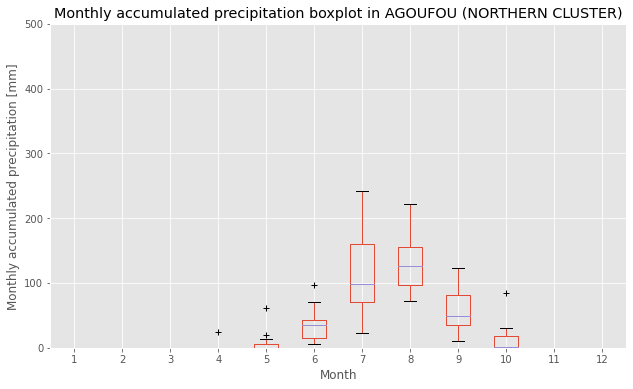

In [13]:
fig = AGOUFOU_monthly.boxplot(column='sumGauge', by=AGOUFOU_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in AGOUFOU (NORTHERN CLUSTER)")
plt.suptitle('')
plt.ylim(0, 500)

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in AGOUFOU.png');

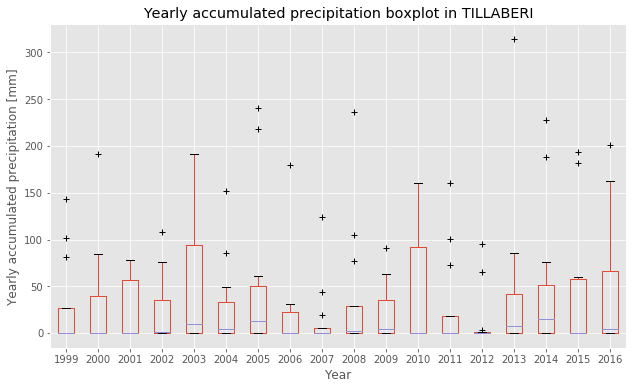

In [15]:
fig = TILLABERI_monthly.boxplot(column='sumGauge', by=TILLABERI_monthly.index.year, sym='+', figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Yearly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Yearly accumulated precipitation boxplot in TILLABERI")
plt.suptitle('')
# plt.xticks(np.arange(0, len(np.unique(TILLABERI_monthly.index.year)), 2), ha='center')

plt.savefig('DataFigures\Yearly accumulated precipitation boxplot in TILLABERI.png');

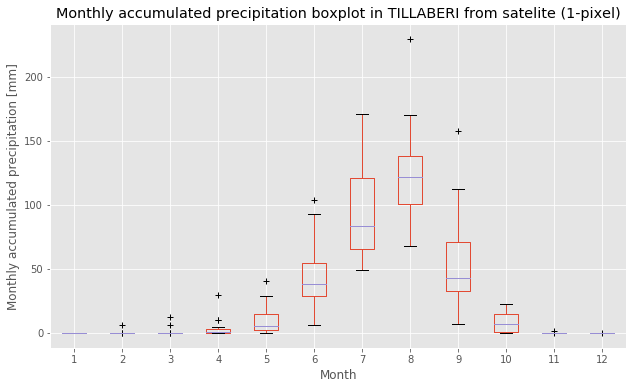

In [17]:
fig = TILLABERI_monthly.boxplot(column='sumSat', by=TILLABERI_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in TILLABERI from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in TILLABERI from satelite (1-pixel).png');

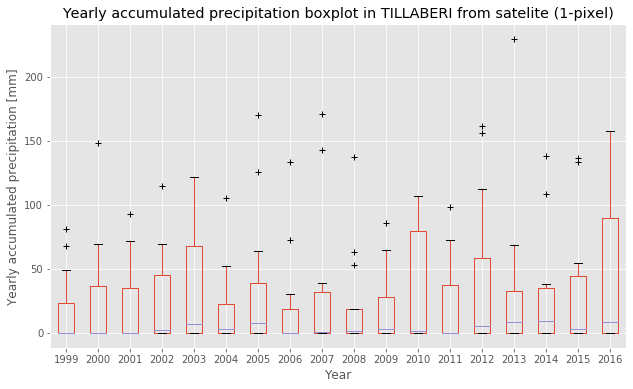

In [34]:
fig = TILLABERI_monthly.boxplot(column='sumSat', by=TILLABERI_monthly.index.year, sym='+', figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Yearly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Yearly accumulated precipitation boxplot in TILLABERI from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Yearly accumulated precipitation boxplot in TILLABERI from satelite (1-pixel).png');

# 2.TOBRE

In [161]:
# needs to be done so that resampling can happen

TOBRE.index = pd.to_datetime(TOBRE.index, errors='coerce')
TOBRE32x32.index = pd.to_datetime(TOBRE32x32.index, errors='coerce')

In [19]:
TOBRE_monthly = pd.DataFrame()

TOBRE_monthly['sumGauge'] = TOBRE['R[mm]'].resample(rule = 'M').sum()
TOBRE_monthly['meanGauge'] = TOBRE['R[mm]'].resample(rule = 'M').mean()

TOBRE_monthly['sumSat'] = TOBRE32x32['R[mm]'].resample(rule = 'M').sum()
TOBRE_monthly['meanSat'] = TOBRE32x32['R[mm]'].resample(rule = 'M').mean()

# TOBRE_monthly.head(10)

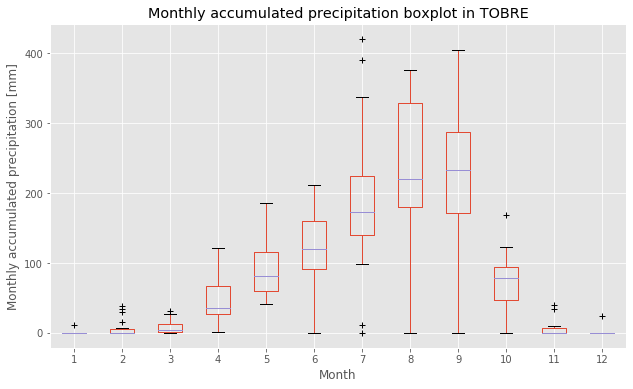

In [20]:
fig = TOBRE_monthly.boxplot(column='sumGauge', by=TOBRE_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in TOBRE")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in TOBRE.png');

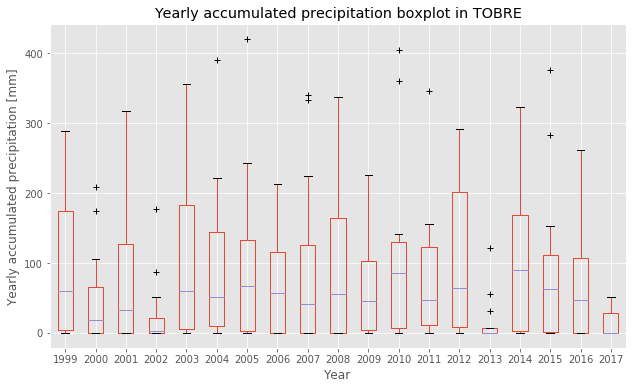

In [35]:
fig = TOBRE_monthly.boxplot(column='sumGauge', by=TOBRE_monthly.index.year, sym='+', figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Yearly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Yearly accumulated precipitation boxplot in TOBRE")
plt.suptitle('')

plt.savefig('DataFigures\Yearly accumulated precipitation boxplot in TOBRE.png');

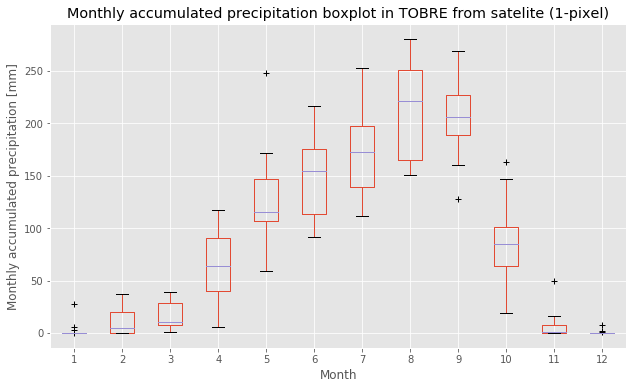

In [21]:
fig = TOBRE_monthly.boxplot(column='sumSat', by=TOBRE_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in TOBRE from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in TOBRE from satelite (1-pixel).png');

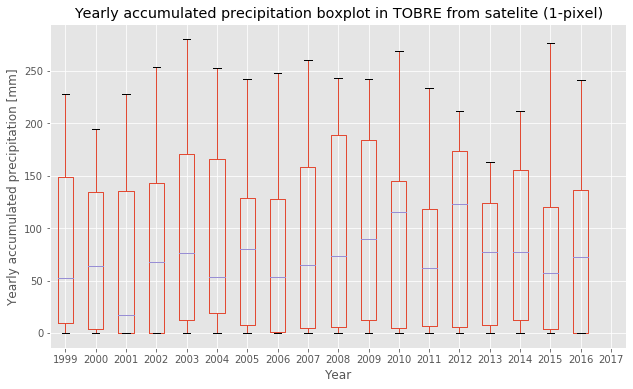

In [36]:
fig = TOBRE_monthly.boxplot(column='sumSat', by=TOBRE_monthly.index.year, sym='+', figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Yearly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Yearly accumulated precipitation boxplot in TOBRE from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Yearly accumulated precipitation boxplot in TOBRE from satelite (1-pixel).png');

# 7. OUAHIGOUYA

In [162]:
# needs to be done so that resampling can happen

OUAHIGOUYA.index = pd.to_datetime(OUAHIGOUYA.index, errors='coerce')
OUAHIGOUYA32x32.index = pd.to_datetime(OUAHIGOUYA32x32.index, errors='coerce')

In [23]:
OUAHIGOUYA_monthly = pd.DataFrame()

OUAHIGOUYA_monthly['sumGauge'] = OUAHIGOUYA['R[mm]'].resample(rule = 'M').sum()
OUAHIGOUYA_monthly['meanGauge'] = OUAHIGOUYA['R[mm]'].resample(rule = 'M').mean()

OUAHIGOUYA_monthly['sumSat'] = OUAHIGOUYA32x32['R[mm]'].resample(rule = 'M').sum()
OUAHIGOUYA_monthly['meanSat'] = OUAHIGOUYA32x32['R[mm]'].resample(rule = 'M').mean()

# OUAHIGOUYA_monthly.head(10)

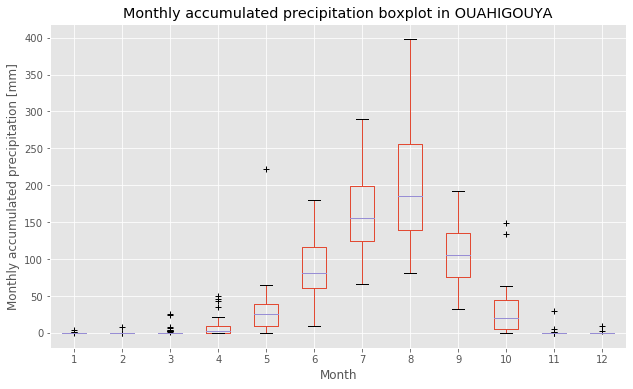

In [24]:
fig = OUAHIGOUYA_monthly.boxplot(column='sumGauge', by=OUAHIGOUYA_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in OUAHIGOUYA")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in OUAHIGOUYA.png');

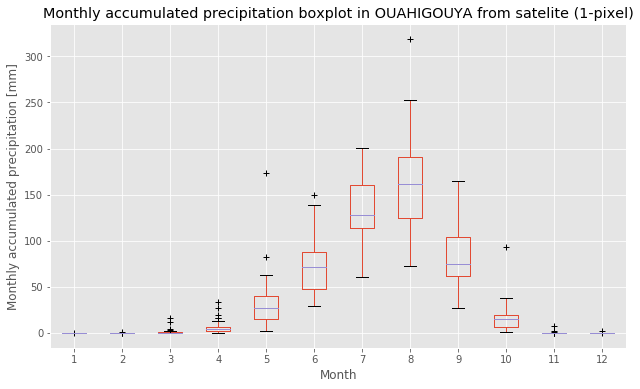

In [25]:
fig = OUAHIGOUYA_monthly.boxplot(column='sumSat', by=OUAHIGOUYA_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in OUAHIGOUYA from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in OUAHIGOUYA from satelite (1-pixel).png');

# 10. ZUARUNGU

In [163]:
# needs to be done so that resampling can happen

ZUARUNGU.index = pd.to_datetime(ZUARUNGU.index, errors='coerce')
ZUARUNGU32x32.index = pd.to_datetime(ZUARUNGU32x32.index, errors='coerce')

In [27]:
ZUARUNGU_monthly = pd.DataFrame()

ZUARUNGU_monthly['sumGauge'] = ZUARUNGU['R[mm]'].resample(rule = 'M').sum()
ZUARUNGU_monthly['meanGauge'] = ZUARUNGU['R[mm]'].resample(rule = 'M').mean()

ZUARUNGU_monthly['sumSat'] = ZUARUNGU32x32['R[mm]'].resample(rule = 'M').sum()
ZUARUNGU_monthly['meanSat'] = ZUARUNGU32x32['R[mm]'].resample(rule = 'M').mean()

# ZUARUNGU_monthly.head(10)

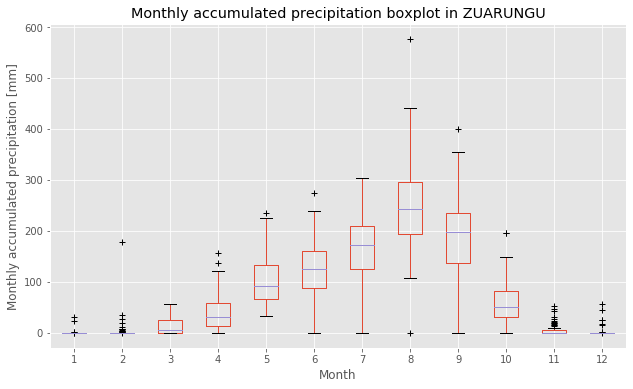

In [28]:
fig = ZUARUNGU_monthly.boxplot(column='sumGauge', by=ZUARUNGU_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in ZUARUNGU")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in ZUARUNGU.png');

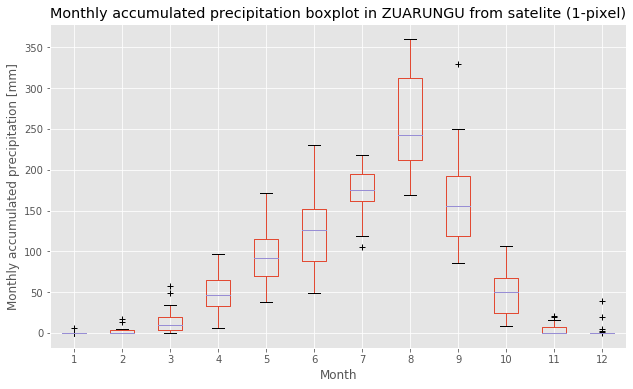

In [29]:
fig = ZUARUNGU_monthly.boxplot(column='sumSat', by=ZUARUNGU_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in ZUARUNGU from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in ZUARUNGU from satelite (1-pixel).png');

# 14. YABOGANE

In [30]:
# needs to be done so that resampling can happen

YABOGANE.index = pd.to_datetime(YABOGANE.index, errors='coerce')
YABOGANE32x32.index = pd.to_datetime(YABOGANE32x32.index, errors='coerce')

In [31]:
YABOGANE_monthly = pd.DataFrame()

YABOGANE_monthly['sumGauge'] = YABOGANE['R[mm]'].resample(rule = 'M').sum()
YABOGANE_monthly['meanGauge'] = YABOGANE['R[mm]'].resample(rule = 'M').mean()

YABOGANE_monthly['sumSat'] = YABOGANE32x32['R[mm]'].resample(rule = 'M').sum()
YABOGANE_monthly['meanSat'] = YABOGANE32x32['R[mm]'].resample(rule = 'M').mean()

# YABOGANE_monthly.head(10)

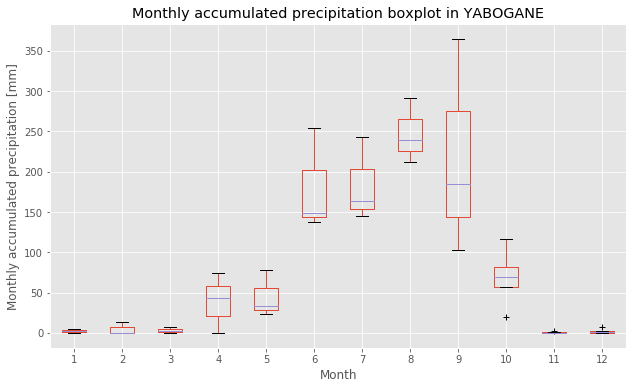

In [32]:
# WE DO NOT HAVE A LOT OF DATA

fig = YABOGANE_monthly.boxplot(column='sumGauge', by=YABOGANE_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in YABOGANE")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in YABOGANE.png');

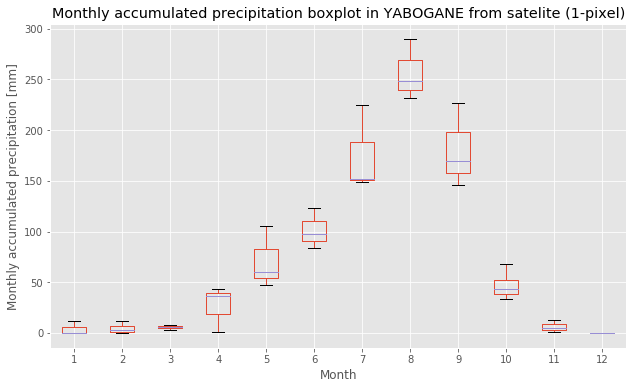

In [33]:
# WE DO NOT HAVE A LOT OF DATA

fig = YABOGANE_monthly.boxplot(column='sumSat', by=YABOGANE_monthly.index.month, sym='+', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Monthly accumulated precipitation [mm]')
fig.get_figure().gca().set_title("Monthly accumulated precipitation boxplot in YABOGANE from satelite (1-pixel)")
plt.suptitle('')

plt.savefig('DataFigures\Monthly accumulated precipitation boxplot in YABOGANE from satelite (1-pixel).png');

# Dry spell analysis
## Dry-spell frequency and Dry-spell maximum duration for the period of May-September

## Set threshold between dry and wet days

In [6]:
thr = 0.8  # mm/d

period = 5  # days, define dry-spell occurance

#  Analysis of the stations one-by-one

# 1. TILLABERI

In [7]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

TILLABERI.index = pd.to_datetime(TILLABERI.index, errors='coerce')
TILLABERI32x32.index = pd.to_datetime(TILLABERI32x32.index, errors='coerce')

TILLABERI = TILLABERI[~TILLABERI.index.month.isin([1, 2, 3, 4, 10, 11, 12])]
TILLABERI32x32 = TILLABERI32x32[~TILLABERI32x32.index.month.isin([1, 2, 3, 4, 10, 11, 12])]
TILLABERI32x32 = TILLABERI32x32[TILLABERI32x32.index.year.isin(np.unique(TILLABERI.index.year))]

In [8]:
TILLABERIspell = pd.DataFrame(data = {'Year': np.unique(TILLABERI.index.year), 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(TILLABERI.index.year))), 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(TILLABERI.index.year))), 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(TILLABERI.index.year))), 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(TILLABERI.index.year))), 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(TILLABERI.index.year))), 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(TILLABERI.index.year)))})
TILLABERIspell.set_index('Year', inplace=True)

TILLABERIspell['Seasonal rainfall [mm] (Gauge)'][:] = TILLABERI['R[mm]'].resample(rule = 'Y').sum()
TILLABERIspell['Seasonal rainfall [mm] (Satelite)'][:] = TILLABERI32x32['R[mm]'].resample(rule = 'Y').sum()

x = TILLABERI[TILLABERI.rolling(period)['R[mm]'].max() <= thr]
TILLABERIspell['Frequency dry-spell (Gauge)'][:] = x.groupby(x.index.year)['R[mm]'].count()
x = TILLABERI32x32[TILLABERI32x32.rolling(period)['R[mm]'].max() <= thr]
TILLABERIspell['Frequency dry-spell (Satelite)'][:] = x.groupby(x.index.year)['R[mm]'].count()

for k in range(len(TILLABERIspell.index)):
    
    i = TILLABERI['R[mm]'][str(TILLABERIspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TILLABERIspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = TILLABERI32x32['R[mm]'][str(TILLABERIspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TILLABERIspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

TILLABERIspell.to_csv("OrganisedData\Dry-spell\TILLABERIspell.csv")

    
TILLABERIspell

C:\Users\panag\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\panag\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1999,24.0,54.0,48,62,340.47,212.619999
2000,49.0,35.0,71,60,362.18,296.559999
2001,27.0,26.0,72,43,279.98,255.400003
2002,31.0,28.0,48,49,268.06,280.059998
2003,16.0,15.0,36,25,545.51,374.850000
2004,19.0,18.0,65,47,322.13,219.990000
2005,21.0,22.0,45,28,587.62,405.220000
2006,37.0,22.0,83,52,275.95,262.699998
2007,66.0,16.0,99,41,187.12,400.140004


In [9]:
x = TILLABERIspell['Frequency dry-spell (Gauge)'].mean()
y = TILLABERIspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for TILLABERI at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TILLABERI at the period of May to September, according to the gauge measurements, is 65.94 and the average maximum annual dry-spell is 34.50 days.


In [10]:
x = TILLABERIspell['Frequency dry-spell (Satelite)'].mean()
y = TILLABERIspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for TILLABERI at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TILLABERI at the period of May to September, according to the satelite measurements, is 44.33 and the average maximum annual dry-spell is 24.22 days.


# 2. TOBRE

In [11]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

TOBRE.index = pd.to_datetime(TOBRE.index, errors='coerce')
TOBRE32x32.index = pd.to_datetime(TOBRE32x32.index, errors='coerce')

TOBRE = TOBRE[~TOBRE.index.month.isin([1, 2, 3, 4, 10, 11, 12])]
TOBRE32x32 = TOBRE32x32[~TOBRE32x32.index.month.isin([1, 2, 3, 4, 10, 11, 12])]
TOBRE32x32 = TOBRE32x32[TOBRE32x32.index.year.isin(np.unique(TOBRE.index.year))]
# repeat bc gauge has more years
TOBRE = TOBRE[TOBRE.index.year.isin(np.unique(TOBRE32x32.index.year))]

In [12]:
TOBREspell = pd.DataFrame(data = {'Year': np.unique(TOBRE.index.year), 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(TOBRE.index.year))), 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(TOBRE.index.year))), 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(TOBRE.index.year))), 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(TOBRE.index.year))), 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(TOBRE.index.year))), 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(TOBRE.index.year)))})
TOBREspell.set_index('Year', inplace=True)

TOBREspell['Seasonal rainfall [mm] (Gauge)'][0:] = TOBRE['R[mm]'].resample(rule = 'Y').sum()[0:]
TOBREspell['Seasonal rainfall [mm] (Satelite)'][0:] = TOBRE32x32['R[mm]'].resample(rule = 'Y').sum()[0:]
    
x = TOBRE[TOBRE.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    TOBREspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = TOBRE32x32[TOBRE32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    TOBREspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
for k in range(len(TOBREspell.index)):
    
    i = TOBRE['R[mm]'][str(TOBREspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TOBREspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = TOBRE32x32['R[mm]'][str(TOBREspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TOBREspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()
    
TOBREspell.to_csv("OrganisedData\Dry-spell\TOBREspell.csv")

    
TOBREspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1999,8.0,4.0,8.0,0.0,962.14,763.739999
2000,10.0,9.0,10.0,8.0,522.46,804.889996
2001,6.0,4.0,6.0,0.0,952.67,858.710002
2002,9.0,4.0,10.0,0.0,240.90,872.230001
2003,15.0,6.0,15.0,2.0,1169.08,1018.399995
2004,11.0,5.0,10.0,2.0,983.74,969.929999
2005,8.0,5.0,14.0,1.0,1023.63,753.430001
2006,10.0,8.0,23.0,4.0,737.72,831.240000
2007,9.0,8.0,14.0,7.0,1056.50,905.679997


In [13]:
x = TOBREspell['Frequency dry-spell (Gauge)'].mean()
y = TOBREspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for TOBRE at the period of April to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TOBRE at the period of April to September, according to the gauge measurements, is 11.17 and the average maximum annual dry-spell is 10.39 days.


In [14]:
x = TOBREspell['Frequency dry-spell (Satelite)'].mean()
y = TOBREspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for TOBRE at the period of April to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TOBRE at the period of April to September, according to the satelite measurements, is 1.83 and the average maximum annual dry-spell is 5.28 days.


# 3. TARA

In [15]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

TARA.index = pd.to_datetime(TARA.index, errors='coerce')
TARA32x32.index = pd.to_datetime(TARA32x32.index, errors='coerce')

TARA = TARA[~TARA.index.month.isin([1, 2, 3, 4, 10, 11, 12])]
TARA32x32 = TARA32x32[~TARA32x32.index.month.isin([1, 2, 3, 4, 10, 11, 12])]
TARA32x32 = TARA32x32[TARA32x32.index.year.isin(np.unique(TARA.index.year))]
# repeat bc gauge has more years
TARA = TARA[TARA.index.year.isin(np.unique(TARA32x32.index.year))]

In [16]:
TARAspell = pd.DataFrame(data = {'Year': np.unique(TARA.index.year), 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(TARA.index.year))), 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(TARA.index.year))), 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(TARA.index.year))), 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(TARA.index.year))), 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(TARA.index.year))), 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(TARA.index.year)))})
TARAspell.set_index('Year', inplace=True)

x = TARA['R[mm]'].resample(rule = 'Y').sum()
x = x.drop(x.index[x.index.year.isin([2007])])  # 2007 is missing from the data
TARAspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = TARA32x32['R[mm]'].resample(rule = 'Y').sum()
x = x.drop(x.index[x.index.year.isin([2007])])  # 2007 is missing from the data
TARAspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = TARA[TARA.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    TARAspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = TARA32x32[TARA32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    TARAspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(TARAspell.index)):
    
    i = TARA['R[mm]'][str(TARAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TARAspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = TARA32x32['R[mm]'][str(TARAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TARAspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

TARAspell.to_csv("OrganisedData\Dry-spell\TARAspell.csv")


TARAspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
2004,36.0,38.0,66.0,63.0,165.0,133.159999
2005,27.0,23.0,58.0,35.0,400.4,319.759999
2006,31.0,27.0,72.0,57.0,313.6,346.739999
2008,29.0,18.0,63.0,44.0,301.2,244.320001
2009,36.0,24.0,63.0,39.0,373.0,318.150000
2010,28.0,35.0,60.0,55.0,350.8,276.039999
2011,32.0,32.0,60.0,46.0,302.5,389.489998
2012,18.0,18.0,43.0,28.0,367.3,551.040002
2013,25.0,25.0,46.0,46.0,303.2,340.930000


In [17]:
x = TARAspell['Frequency dry-spell (Gauge)'].mean()
y = TARAspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for TARA at the period of April to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TARA at the period of April to September, according to the gauge measurements, is 59.08 and the average maximum annual dry-spell is 28.92 days.


In [18]:
x = TARAspell['Frequency dry-spell (Satelite)'].mean()
y = TARAspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for TARA at the period of April to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TARA at the period of April to September, according to the satelite measurements, is 43.50 and the average maximum annual dry-spell is 25.17 days.


# 4. AGOUFOU

In [19]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

AGOUFOU.index = pd.to_datetime(AGOUFOU.index, errors='coerce')
AGOUFOU32x32.index = pd.to_datetime(AGOUFOU32x32.index, errors='coerce')

AGOUFOU = AGOUFOU[~AGOUFOU.index.month.isin([1, 2, 3, 10, 11, 12])]
AGOUFOU32x32 = AGOUFOU32x32[~AGOUFOU32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
AGOUFOU32x32 = AGOUFOU32x32[AGOUFOU32x32.index.year.isin(np.unique(AGOUFOU.index.year))]
# repeat bc gauge has more years
AGOUFOU = AGOUFOU[AGOUFOU.index.year.isin(np.unique(AGOUFOU32x32.index.year))]

In [20]:
AGOUFOUspell = pd.DataFrame(data = {'Year': np.unique(AGOUFOU.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(AGOUFOU.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(AGOUFOU.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(AGOUFOU.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(AGOUFOU.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(AGOUFOU.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(AGOUFOU.index.year)))
                                })

AGOUFOUspell.set_index('Year', inplace=True)

x = AGOUFOU['R[mm]'].resample(rule = 'Y').sum()
AGOUFOUspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = AGOUFOU32x32['R[mm]'].resample(rule = 'Y').sum()
AGOUFOUspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = AGOUFOU[AGOUFOU.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    AGOUFOUspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = AGOUFOU32x32[AGOUFOU32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    AGOUFOUspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(AGOUFOUspell.index)):
    
    i = AGOUFOU['R[mm]'][str(AGOUFOUspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    AGOUFOUspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = AGOUFOU32x32['R[mm]'][str(AGOUFOUspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    AGOUFOUspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

AGOUFOUspell.to_csv("OrganisedData\Dry-spell\AGOUFOUspell.csv")


AGOUFOUspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
2003,47.0,32.0,57.0,73.0,461.5,338.040000
2004,36.0,53.0,76.0,94.0,166.5,135.080001
2005,18.0,36.0,45.0,64.0,407.5,302.389999
2006,40.0,57.0,60.0,82.0,449.5,299.640000
2007,36.0,66.0,59.0,85.0,329.0,259.280001
2008,35.0,28.0,55.0,72.0,270.0,232.840001
2009,42.0,71.0,66.0,76.0,297.7,301.179997
2010,59.0,65.0,70.0,82.0,430.5,267.860000
2011,19.0,62.0,48.0,77.0,495.0,377.080002


In [21]:
x = AGOUFOUspell['Frequency dry-spell (Gauge)'].mean()
y = AGOUFOUspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for AGOUFOU at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for AGOUFOU at the period of May to September, according to the gauge measurements, is 62.43 and the average maximum annual dry-spell is 35.57 days.


In [22]:
x = AGOUFOUspell['Frequency dry-spell (Satelite)'].mean()
y = AGOUFOUspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for AGOUFOU at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for AGOUFOU at the period of May to September, according to the satelite measurements, is 74.79 and the average maximum annual dry-spell is 49.43 days.


# 5. LAWRA

In [23]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

LAWRA.index = pd.to_datetime(LAWRA.index, errors='coerce')
LAWRA32x32.index = pd.to_datetime(LAWRA32x32.index, errors='coerce')

LAWRA = LAWRA[~LAWRA.index.month.isin([1, 2, 3, 10, 11, 12])]
LAWRA32x32 = LAWRA32x32[~LAWRA32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
LAWRA32x32 = LAWRA32x32[LAWRA32x32.index.year.isin(np.unique(LAWRA.index.year))]
# repeat bc gauge has more years
LAWRA = LAWRA[LAWRA.index.year.isin(np.unique(LAWRA32x32.index.year))]

In [24]:
LAWRAspell = pd.DataFrame(data = {'Year': np.unique(LAWRA.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(LAWRA.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(LAWRA.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(LAWRA.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(LAWRA.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(LAWRA.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(LAWRA.index.year)))
                                })

LAWRAspell.set_index('Year', inplace=True)

x = LAWRA['R[mm]'].resample(rule = 'Y').sum()
LAWRAspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = LAWRA32x32['R[mm]'].resample(rule = 'Y').sum()
LAWRAspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = LAWRA[LAWRA.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    LAWRAspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = LAWRA32x32[LAWRA32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    LAWRAspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(LAWRAspell.index)):
    
    i = LAWRA['R[mm]'][str(LAWRAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    LAWRAspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = LAWRA32x32['R[mm]'][str(LAWRAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    LAWRAspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

LAWRAspell.to_csv("OrganisedData\Dry-spell\LAWRAspell.csv")


LAWRAspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1980,15.0,9.0,48.0,8.0,595.8,852.830001
1981,13.0,13.0,37.0,13.0,329.0,819.860002
1982,23.0,13.0,54.0,10.0,349.6,802.750001
1983,20.0,13.0,66.0,18.0,147.6,691.319999
1984,NaN,8.0,0.0,13.0,0.0,649.190000
1985,NaN,9.0,0.0,15.0,0.0,817.399995
1986,NaN,11.0,0.0,11.0,0.0,1019.580000
1987,NaN,48.0,0.0,44.0,0.0,790.460001
1988,16.0,10.0,52.0,12.0,265.0,754.070000


In [25]:
x = LAWRAspell['Frequency dry-spell (Gauge)'].mean()
y = LAWRAspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for LAWRA at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for LAWRA at the period of May to September, according to the gauge measurements, is 25.74 and the average maximum annual dry-spell is 13.89 days.


In [26]:
x = LAWRAspell['Frequency dry-spell (Satelite)'].mean()
y = LAWRAspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for LAWRA at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for LAWRA at the period of May to September, according to the satelite measurements, is 15.74 and the average maximum annual dry-spell is 12.22 days.


# 6. NAVRONGO

In [27]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

NAVRONGO.index = pd.to_datetime(NAVRONGO.index, errors='coerce')
NAVRONGO32x32.index = pd.to_datetime(NAVRONGO32x32.index, errors='coerce')

NAVRONGO = NAVRONGO[~NAVRONGO.index.month.isin([1, 2, 3, 10, 11, 12])]
NAVRONGO32x32 = NAVRONGO32x32[~NAVRONGO32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
NAVRONGO32x32 = NAVRONGO32x32[NAVRONGO32x32.index.year.isin(np.unique(NAVRONGO.index.year))]
# repeat bc gauge has more years
NAVRONGO = NAVRONGO[NAVRONGO.index.year.isin(np.unique(NAVRONGO32x32.index.year))]

In [29]:
NAVRONGOspell = pd.DataFrame(data = {'Year': np.unique(NAVRONGO.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(NAVRONGO.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(NAVRONGO.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(NAVRONGO.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(NAVRONGO.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(NAVRONGO.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(NAVRONGO.index.year)))
                                })

NAVRONGOspell.set_index('Year', inplace=True)

x = NAVRONGO['R[mm]'].resample(rule = 'Y').sum()
NAVRONGOspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = NAVRONGO32x32['R[mm]'].resample(rule = 'Y').sum()
NAVRONGOspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = NAVRONGO[NAVRONGO.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    NAVRONGOspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = NAVRONGO32x32[NAVRONGO32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    NAVRONGOspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(NAVRONGOspell.index)):
    
    i = NAVRONGO['R[mm]'][str(NAVRONGOspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    NAVRONGOspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = NAVRONGO32x32['R[mm]'][str(NAVRONGOspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    NAVRONGOspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

NAVRONGOspell.to_csv("OrganisedData\Dry-spell\\NAVRONGOspell.csv")


NAVRONGOspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1980,15.0,15.0,38.0,17.0,870.2,914.770002
1981,16.0,11.0,36.0,13.0,812.8,922.410009
1982,8.0,6.0,24.0,9.0,889.1,801.440004
1983,25.0,14.0,46.0,25.0,718.0,685.290003
1984,12.0,8.0,30.0,21.0,806.4,717.790002
1985,28.0,17.0,43.0,26.0,950.5,870.470003
1986,11.0,5.0,21.0,3.0,1169.0,960.049995
1987,38.0,39.0,45.0,35.0,1001.5,867.069995
1988,12.0,10.0,20.0,14.0,861.2,824.669999


In [30]:
x = NAVRONGOspell['Frequency dry-spell (Gauge)'].mean()
y = NAVRONGOspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for NAVRONGO at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for NAVRONGO at the period of May to September, according to the gauge measurements, is 33.93 and the average maximum annual dry-spell is 16.34 days.


In [31]:
x = NAVRONGOspell['Frequency dry-spell (Satelite)'].mean()
y = NAVRONGOspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for NAVRONGO at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for NAVRONGO at the period of May to September, according to the satelite measurements, is 15.10 and the average maximum annual dry-spell is 11.14 days.


# 7. OUAHIGOUYA

In [32]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

OUAHIGOUYA.index = pd.to_datetime(OUAHIGOUYA.index, errors='coerce')
OUAHIGOUYA32x32.index = pd.to_datetime(OUAHIGOUYA32x32.index, errors='coerce')

OUAHIGOUYA = OUAHIGOUYA[~OUAHIGOUYA.index.month.isin([1, 2, 3, 10, 11, 12])]
OUAHIGOUYA32x32 = OUAHIGOUYA32x32[~OUAHIGOUYA32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
OUAHIGOUYA32x32 = OUAHIGOUYA32x32[OUAHIGOUYA32x32.index.year.isin(np.unique(OUAHIGOUYA.index.year))]
# repeat bc gauge has more years
OUAHIGOUYA = OUAHIGOUYA[OUAHIGOUYA.index.year.isin(np.unique(OUAHIGOUYA32x32.index.year))]

In [33]:
OUAHIGOUYAspell = pd.DataFrame(data = {'Year': np.unique(OUAHIGOUYA.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(OUAHIGOUYA.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(OUAHIGOUYA.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(OUAHIGOUYA.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(OUAHIGOUYA.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(OUAHIGOUYA.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(OUAHIGOUYA.index.year)))
                                })

OUAHIGOUYAspell.set_index('Year', inplace=True)

x = OUAHIGOUYA['R[mm]'].resample(rule = 'Y').sum()
OUAHIGOUYAspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = OUAHIGOUYA32x32['R[mm]'].resample(rule = 'Y').sum()
OUAHIGOUYAspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = OUAHIGOUYA[OUAHIGOUYA.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    OUAHIGOUYAspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = OUAHIGOUYA32x32[OUAHIGOUYA32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    OUAHIGOUYAspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(OUAHIGOUYAspell.index)):
    
    i = OUAHIGOUYA['R[mm]'][str(OUAHIGOUYAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    OUAHIGOUYAspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = OUAHIGOUYA32x32['R[mm]'][str(OUAHIGOUYAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    OUAHIGOUYAspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

OUAHIGOUYAspell.to_csv("OrganisedData\Dry-spell\OUAHIGOUYAspell.csv")


OUAHIGOUYAspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1980,28.0,20.0,56.0,42.0,549.8,480.180003
1981,18.0,17.0,45.0,42.0,778.7,611.680001
1982,19.0,22.0,73.0,61.0,342.4,348.979999
1983,37.0,35.0,56.0,43.0,356.8,362.709998
1984,38.0,23.0,64.0,50.0,370.5,396.140000
1985,26.0,27.0,73.0,64.0,418.1,398.050000
1986,19.0,32.0,41.0,46.0,582.4,430.290006
1987,63.0,63.0,75.0,70.0,460.3,347.910000
1988,48.0,29.0,77.0,55.0,706.2,562.700001


In [34]:
x = OUAHIGOUYAspell['Frequency dry-spell (Gauge)'].mean()
y = OUAHIGOUYAspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for OUAHIGOUYA at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for OUAHIGOUYA at the period of May to September, according to the gauge measurements, is 59.03 and the average maximum annual dry-spell is 32.10 days.


In [35]:
x = OUAHIGOUYAspell['Frequency dry-spell (Satelite)'].mean()
y = OUAHIGOUYAspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for OUAHIGOUYA at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for OUAHIGOUYA at the period of May to September, according to the satelite measurements, is 46.83 and the average maximum annual dry-spell is 28.03 days.


# 8. TAMALE

In [36]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

TAMALE.index = pd.to_datetime(TAMALE.index, errors='coerce')
TAMALE32x32.index = pd.to_datetime(TAMALE32x32.index, errors='coerce')

TAMALE = TAMALE[~TAMALE.index.month.isin([1, 2, 3, 10, 11, 12])]
TAMALE32x32 = TAMALE32x32[~TAMALE32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
TAMALE32x32 = TAMALE32x32[TAMALE32x32.index.year.isin(np.unique(TAMALE.index.year))]
# repeat bc gauge has more years
TAMALE = TAMALE[TAMALE.index.year.isin(np.unique(TAMALE32x32.index.year))]

In [37]:
TAMALEspell = pd.DataFrame(data = {'Year': np.unique(TAMALE.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(TAMALE.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(TAMALE.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(TAMALE.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(TAMALE.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(TAMALE.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(TAMALE.index.year)))
                                })

TAMALEspell.set_index('Year', inplace=True)

x = TAMALE['R[mm]'].resample(rule = 'Y').sum()
TAMALEspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = TAMALE32x32['R[mm]'].resample(rule = 'Y').sum()
TAMALEspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = TAMALE[TAMALE.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    TAMALEspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = TAMALE32x32[TAMALE32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    TAMALEspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(TAMALEspell.index)):
    
    i = TAMALE['R[mm]'][str(TAMALEspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TAMALEspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = TAMALE32x32['R[mm]'][str(TAMALEspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    TAMALEspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

TAMALEspell.to_csv("OrganisedData\Dry-spell\TAMALEspell.csv")


TAMALEspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1980,10.0,5.0,24.0,4.0,928.7,967.580007
1981,12.0,8.0,29.0,5.0,1036.1,1055.690004
1982,18.0,5.0,47.0,2.0,1036.1,919.740003
1983,21.0,11.0,43.0,15.0,733.5,735.780000
1984,13.0,8.0,29.0,8.0,850.7,951.130000
1985,9.0,10.0,19.0,10.0,947.4,1021.240003
1986,11.0,6.0,22.0,4.0,880.8,934.989999
1987,34.0,12.0,41.0,19.0,821.0,863.410000
1988,15.0,4.0,28.0,0.0,1026.0,1004.329999


In [38]:
x = TAMALEspell['Frequency dry-spell (Gauge)'].mean()
y = TAMALEspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for TAMALE at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TAMALE at the period of May to September, according to the gauge measurements, is 29.48 and the average maximum annual dry-spell is 13.79 days.


In [39]:
x = TAMALEspell['Frequency dry-spell (Satelite)'].mean()
y = TAMALEspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for TAMALE at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for TAMALE at the period of May to September, according to the satelite measurements, is 7.31 and the average maximum annual dry-spell is 8.07 days.


# 9. WA

In [40]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

WA.index = pd.to_datetime(WA.index, errors='coerce')
WA32x32.index = pd.to_datetime(WA32x32.index, errors='coerce')

WA = WA[~WA.index.month.isin([1, 2, 3, 10, 11, 12])]
WA32x32 = WA32x32[~WA32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
WA32x32 = WA32x32[WA32x32.index.year.isin(np.unique(WA.index.year))]
# repeat bc gauge has more years
WA = WA[WA.index.year.isin(np.unique(WA32x32.index.year))]

In [41]:
WAspell = pd.DataFrame(data = {'Year': np.unique(WA.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(WA.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(WA.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(WA.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(WA.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(WA.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(WA.index.year)))
                                })

WAspell.set_index('Year', inplace=True)

x = WA['R[mm]'].resample(rule = 'Y').sum()
WAspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = WA32x32['R[mm]'].resample(rule = 'Y').sum()
WAspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = WA[WA.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    WAspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = WA32x32[WA32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    WAspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(WAspell.index)):
    
    i = WA['R[mm]'][str(WAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    WAspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = WA32x32['R[mm]'][str(WAspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    WAspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

WAspell.to_csv("OrganisedData\Dry-spell\WAspell.csv")


WAspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1980,15.0,10.0,45.0,8.0,857.7,860.959999
1981,8.0,8.0,31.0,10.0,619.4,671.239997
1982,11.0,6.0,17.0,7.0,874.0,763.700001
1983,14.0,11.0,43.0,12.0,567.1,603.879999
1984,13.0,7.0,31.0,6.0,830.6,806.540004
1985,9.0,7.0,21.0,4.0,968.9,991.610004
1986,13.0,10.0,35.0,10.0,479.4,643.889997
1987,20.0,17.0,34.0,16.0,660.5,764.830004
1988,13.0,5.0,23.0,1.0,752.4,853.250000


In [42]:
x = WAspell['Frequency dry-spell (Gauge)'].mean()
y = WAspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for WA at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for WA at the period of May to September, according to the gauge measurements, is 24.20 and the average maximum annual dry-spell is 11.32 days.


In [43]:
x = WAspell['Frequency dry-spell (Satelite)'].mean()
y = WAspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for WA at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for WA at the period of May to September, according to the satelite measurements, is 8.60 and the average maximum annual dry-spell is 8.56 days.


# 10. ZUARUNGU

In [44]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

ZUARUNGU.index = pd.to_datetime(ZUARUNGU.index, errors='coerce')
ZUARUNGU32x32.index = pd.to_datetime(ZUARUNGU32x32.index, errors='coerce')

ZUARUNGU = ZUARUNGU[~ZUARUNGU.index.month.isin([1, 2, 3, 10, 11, 12])]
ZUARUNGU32x32 = ZUARUNGU32x32[~ZUARUNGU32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
ZUARUNGU32x32 = ZUARUNGU32x32[ZUARUNGU32x32.index.year.isin(np.unique(ZUARUNGU.index.year))]
# repeat bc gauge has more years
ZUARUNGU = ZUARUNGU[ZUARUNGU.index.year.isin(np.unique(ZUARUNGU32x32.index.year))]

In [45]:
ZUARUNGUspell = pd.DataFrame(data = {'Year': np.unique(ZUARUNGU.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(ZUARUNGU.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(ZUARUNGU.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(ZUARUNGU.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(ZUARUNGU.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(ZUARUNGU.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(ZUARUNGU.index.year)))
                                })

ZUARUNGUspell.set_index('Year', inplace=True)

x = ZUARUNGU['R[mm]'].resample(rule = 'Y').sum()
ZUARUNGUspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = ZUARUNGU32x32['R[mm]'].resample(rule = 'Y').sum()
ZUARUNGUspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = ZUARUNGU[ZUARUNGU.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    ZUARUNGUspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = ZUARUNGU32x32[ZUARUNGU32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    ZUARUNGUspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(ZUARUNGUspell.index)):
    
    i = ZUARUNGU['R[mm]'][str(ZUARUNGUspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    ZUARUNGUspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = ZUARUNGU32x32['R[mm]'][str(ZUARUNGUspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    ZUARUNGUspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

ZUARUNGUspell.to_csv("OrganisedData\Dry-spell\ZUARUNGUspell.csv")


ZUARUNGUspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
1980,14.0,15.0,32.0,16.0,675.4,896.059999
1981,16.0,14.0,39.0,20.0,646.6,815.509998
1982,8.0,12.0,23.0,16.0,974.4,801.750003
1983,29.0,14.0,55.0,18.0,885.1,716.929997
1984,17.0,9.0,42.0,20.0,635.8,672.080001
1985,15.0,12.0,30.0,23.0,755.8,826.580000
1986,10.0,13.0,21.0,14.0,878.0,956.409997
1987,47.0,39.0,51.0,44.0,851.9,852.360001
1988,16.0,10.0,41.0,13.0,849.5,846.670008


In [46]:
x = ZUARUNGUspell['Frequency dry-spell (Gauge)'].mean()
y = ZUARUNGUspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for ZUARUNGU at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for ZUARUNGU at the period of May to September, according to the gauge measurements, is 36.24 and the average maximum annual dry-spell is 17.80 days.


In [47]:
x = ZUARUNGUspell['Frequency dry-spell (Satelite)'].mean()
y = ZUARUNGUspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for ZUARUNGU at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for ZUARUNGU at the period of May to September, according to the satelite measurements, is 18.44 and the average maximum annual dry-spell is 12.80 days.


# 11. ANIABISI

In [48]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

ANIABISI.index = pd.to_datetime(ANIABISI.index, errors='coerce')
ANIABISI32x32.index = pd.to_datetime(ANIABISI32x32.index, errors='coerce')

ANIABISI = ANIABISI[~ANIABISI.index.month.isin([1, 2, 3, 10, 11, 12])]
ANIABISI32x32 = ANIABISI32x32[~ANIABISI32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
ANIABISI32x32 = ANIABISI32x32[ANIABISI32x32.index.year.isin(np.unique(ANIABISI.index.year))]
# repeat bc gauge has more years
ANIABISI = ANIABISI[ANIABISI.index.year.isin(np.unique(ANIABISI32x32.index.year))]

In [49]:
ANIABISIspell = pd.DataFrame(data = {'Year': np.unique(ANIABISI.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(ANIABISI.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(ANIABISI.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(ANIABISI.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(ANIABISI.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(ANIABISI.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(ANIABISI.index.year)))
                                })

ANIABISIspell.set_index('Year', inplace=True)

x = ANIABISI['R[mm]'].resample(rule = 'Y').sum()
ANIABISIspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = ANIABISI32x32['R[mm]'].resample(rule = 'Y').sum()
ANIABISIspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = ANIABISI[ANIABISI.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    ANIABISIspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = ANIABISI32x32[ANIABISI32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    ANIABISIspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(ANIABISIspell.index)):
    
    i = ANIABISI['R[mm]'][str(ANIABISIspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    ANIABISIspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = ANIABISI32x32['R[mm]'][str(ANIABISIspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    ANIABISIspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

ANIABISIspell.to_csv("OrganisedData\Dry-spell\ANIABISIspell.csv")


ANIABISIspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
2014,7.0,16.0,10.0,30.0,611.20,602.669997
2015,26.0,21.0,54.0,32.0,810.55,778.580000


In [50]:
x = ANIABISIspell['Frequency dry-spell (Gauge)'].mean()
y = ANIABISIspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for ANIABISI at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for ANIABISI at the period of May to September, according to the gauge measurements, is 32.00 and the average maximum annual dry-spell is 16.50 days.


In [51]:
x = ANIABISIspell['Frequency dry-spell (Satelite)'].mean()
y = ANIABISIspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for ANIABISI at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for ANIABISI at the period of May to September, according to the satelite measurements, is 31.00 and the average maximum annual dry-spell is 18.50 days.


# 12. POUDRI

In [52]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

POUDRI.index = pd.to_datetime(POUDRI.index, errors='coerce')
POUDRI32x32.index = pd.to_datetime(POUDRI32x32.index, errors='coerce')

POUDRI = POUDRI[~POUDRI.index.month.isin([1, 2, 3, 10, 11, 12])]
POUDRI32x32 = POUDRI32x32[~POUDRI32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
POUDRI32x32 = POUDRI32x32[POUDRI32x32.index.year.isin(np.unique(POUDRI.index.year))]
# repeat bc gauge has more years
POUDRI = POUDRI[POUDRI.index.year.isin(np.unique(POUDRI32x32.index.year))]

In [53]:
POUDRIspell = pd.DataFrame(data = {'Year': np.unique(POUDRI.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(POUDRI.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(POUDRI.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(POUDRI.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(POUDRI.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(POUDRI.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(POUDRI.index.year)))
                                })

POUDRIspell.set_index('Year', inplace=True)

x = POUDRI['R[mm]'].resample(rule = 'Y').sum()
POUDRIspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = POUDRI32x32['R[mm]'].resample(rule = 'Y').sum()
POUDRIspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = POUDRI[POUDRI.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    POUDRIspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = POUDRI32x32[POUDRI32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    POUDRIspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(POUDRIspell.index)):
    
    i = POUDRI['R[mm]'][str(POUDRIspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    POUDRIspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = POUDRI32x32['R[mm]'][str(POUDRIspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    POUDRIspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

POUDRIspell.to_csv("OrganisedData\Dry-spell\POUDRIspell.csv")


POUDRIspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
2013,8.0,9.0,4.0,5.0,699.65,802.629996
2014,12.0,12.0,28.0,13.0,670.52,816.539998
2015,23.0,21.0,40.0,30.0,764.30,838.169999


In [54]:
x = POUDRIspell['Frequency dry-spell (Gauge)'].mean()
y = POUDRIspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for POUDRI at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for POUDRI at the period of May to September, according to the gauge measurements, is 24.00 and the average maximum annual dry-spell is 14.33 days.


In [55]:
x = POUDRIspell['Frequency dry-spell (Satelite)'].mean()
y = POUDRIspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for POUDRI at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for POUDRI at the period of May to September, according to the satelite measurements, is 16.00 and the average maximum annual dry-spell is 14.00 days.


# 13. LARE

In [56]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

LARE.index = pd.to_datetime(LARE.index, errors='coerce')
LARE32x32.index = pd.to_datetime(LARE32x32.index, errors='coerce')

LARE = LARE[~LARE.index.month.isin([1, 2, 3, 10, 11, 12])]
LARE32x32 = LARE32x32[~LARE32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
LARE32x32 = LARE32x32[LARE32x32.index.year.isin(np.unique(LARE.index.year))]
# repeat bc gauge has more years
LARE = LARE[LARE.index.year.isin(np.unique(LARE32x32.index.year))]

In [57]:
LAREspell = pd.DataFrame(data = {'Year': np.unique(LARE.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(LARE.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(LARE.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(LARE.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(LARE.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(LARE.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(LARE.index.year)))
                                })

LAREspell.set_index('Year', inplace=True)

x = LARE['R[mm]'].resample(rule = 'Y').sum()
LAREspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = LARE32x32['R[mm]'].resample(rule = 'Y').sum()
LAREspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = LARE[LARE.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    LAREspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = LARE32x32[LARE32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    LAREspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(LAREspell.index)):
    
    i = LARE['R[mm]'][str(LAREspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    LAREspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = LARE32x32['R[mm]'][str(LAREspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    LAREspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

LAREspell.to_csv("OrganisedData\Dry-spell\LAREspell.csv")


LAREspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
2013,2.0,9.0,0.0,11.0,35.20,862.290000
2014,11.0,9.0,27.0,14.0,779.80,822.659999
2015,32.0,32.0,36.0,29.0,978.95,826.150004


In [58]:
x = LAREspell['Frequency dry-spell (Gauge)'].mean()
y = LAREspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for LARE at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for LARE at the period of May to September, according to the gauge measurements, is 21.00 and the average maximum annual dry-spell is 15.00 days.


In [59]:
x = LAREspell['Frequency dry-spell (Satelite)'].mean()
y = LAREspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for LARE at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for LARE at the period of May to September, according to the satelite measurements, is 18.00 and the average maximum annual dry-spell is 16.67 days.


# 14. YABOGANE

In [60]:
# first we have to drop the other months and years

# needs to be done so that resampling can happen

YABOGANE.index = pd.to_datetime(YABOGANE.index, errors='coerce')
YABOGANE32x32.index = pd.to_datetime(YABOGANE32x32.index, errors='coerce')

YABOGANE = YABOGANE[~YABOGANE.index.month.isin([1, 2, 3, 10, 11, 12])]
YABOGANE32x32 = YABOGANE32x32[~YABOGANE32x32.index.month.isin([1, 2, 3, 10, 11, 12])]
YABOGANE32x32 = YABOGANE32x32[YABOGANE32x32.index.year.isin(np.unique(YABOGANE.index.year))]
# repeat bc gauge has more years
YABOGANE = YABOGANE[YABOGANE.index.year.isin(np.unique(YABOGANE32x32.index.year))]

In [61]:
YABOGANEspell = pd.DataFrame(data = {'Year': np.unique(YABOGANE.index.year), 
                                 'Max dry-spell [days] (Gauge)': np.zeros(len(np.unique(YABOGANE.index.year))), 
                                 'Max dry-spell [days] (Satelite)': np.zeros(len(np.unique(YABOGANE.index.year))), 
                                 'Frequency dry-spell (Gauge)': np.zeros(len(np.unique(YABOGANE.index.year))), 
                                 'Frequency dry-spell (Satelite)': np.zeros(len(np.unique(YABOGANE.index.year))), 
                                 'Seasonal rainfall [mm] (Gauge)': np.zeros(len(np.unique(YABOGANE.index.year))), 
                                 'Seasonal rainfall [mm] (Satelite)': np.zeros(len(np.unique(YABOGANE.index.year)))
                                })

YABOGANEspell.set_index('Year', inplace=True)

x = YABOGANE['R[mm]'].resample(rule = 'Y').sum()
YABOGANEspell['Seasonal rainfall [mm] (Gauge)'][:] = x

x = YABOGANE32x32['R[mm]'].resample(rule = 'Y').sum()
YABOGANEspell['Seasonal rainfall [mm] (Satelite)'][:] = x

x = YABOGANE[YABOGANE.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    YABOGANEspell['Frequency dry-spell (Gauge)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
x = YABOGANE32x32[YABOGANE32x32.rolling(period)['R[mm]'].max() <= thr]
years = np.unique(x.groupby(x.index.year)['R[mm]'].count().index)

for i in range(len(years)):
    YABOGANEspell['Frequency dry-spell (Satelite)'][years[i]] = x.groupby(x.index.year)['R[mm]'].count()[years[i]]
    
    
for k in range(len(YABOGANEspell.index)):
    
    i = YABOGANE['R[mm]'][str(YABOGANEspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    YABOGANEspell['Max dry-spell [days] (Gauge)'].iloc[[k]] = j[i].value_counts().max()
    
    i = YABOGANE32x32['R[mm]'][str(YABOGANEspell.index[k])] < thr
    j = i.ne(i.shift()).cumsum()
    YABOGANEspell['Max dry-spell [days] (Satelite)'].iloc[[k]] = j[i].value_counts().max()

YABOGANEspell.to_csv("OrganisedData\Dry-spell\YABOGANEspell.csv")


YABOGANEspell

,Max dry-spell [days] (Gauge),Max dry-spell [days] (Satelite),Frequency dry-spell (Gauge),Frequency dry-spell (Satelite),Seasonal rainfall [mm] (Gauge),Seasonal rainfall [mm] (Satelite)
Year,,,,,,
2013,12.0,10.0,23.0,13.0,894.90,848.900002
2014,10.0,8.0,18.0,7.0,862.30,786.949999
2015,32.0,20.0,37.0,24.0,984.65,801.590002


In [62]:
x = YABOGANEspell['Frequency dry-spell (Gauge)'].mean()
y = YABOGANEspell['Max dry-spell [days] (Gauge)'].mean()

print(f'The average annual frequency of dry-spell for YABOGANE at the period of May to September, according to the gauge measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for YABOGANE at the period of May to September, according to the gauge measurements, is 26.00 and the average maximum annual dry-spell is 18.00 days.


In [63]:
x = YABOGANEspell['Frequency dry-spell (Satelite)'].mean()
y = YABOGANEspell['Max dry-spell [days] (Satelite)'].mean()

print(f'The average annual frequency of dry-spell for YABOGANE at the period of May to September, according to the satelite measurements, is {x:.2f} and the average maximum annual dry-spell is {y:.2f} days.')

The average annual frequency of dry-spell for YABOGANE at the period of May to September, according to the satelite measurements, is 14.67 and the average maximum annual dry-spell is 12.67 days.
